In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
module_path = os.path.abspath('../modules')
print(f"Adding '{module_path}' to sys.path")
sys.path.append(module_path)

from data_preprocessing import test_function
print(test_function())


Adding 'C:\Users\madinah\product-demand-forecasting\modules' to sys.path
It works!


In [4]:
from data_preprocessing import get_data, clean_data
from text_processing import TextProcessor
from text_processing import ProductCategorizer
from feature_extraction import EuropeanHolidays, FeatureExtractor
from feature_transformation import encode_categorical
from modeling import DemandForecastingModel

ImportError: cannot import name 'DemandForecastingModel' from 'modeling' (C:\Users\madinah\product-demand-forecasting\modules\modeling.py)

## Get the Data

In [ ]:
df_orig = get_data()
df_orig.head()

In [5]:
# Read the Excel file into a DataFrame
df_orig = pd.read_excel('C:/Users/madinah/Online Retail.xlsx')
df_orig.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df_orig.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df_orig.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


## Data Cleaning

In [8]:
df = clean_data(df_orig)
print("Before cleaning:", len(df_orig))
print("After cleaning:", len(df))
print(f"{len(df_orig) - len(df)} rows removed")

Before cleaning: 535940
After cleaning: 522911
13029 rows removed


In [ ]:
dfd = clean_data(df_orig)
dfd['TotalPrice'] = dfd['Quantity'] * dfd['UnitPrice']

dfd.plot(kind='scatter', x='Quantity', y='TotalPrice')
plt.title('Quantity vs. Price')
plt.xlabel('Quantity')
plt.ylabel('TotalPrice')
plt.show();

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.describe().T

In [ ]:
# Assert conditions

# Assert no rows with negative Quantity values
assert (df['Quantity'] >= 0).all()

# Assert no rows with UnitPrice equal to 0
assert (df['UnitPrice'] != 0).all()

# Assert there are no NA values
assert df.isna().sum().sum() == 0, "There are NA values in the DataFrame"

# Assert that all specified columns are not present in the DataFrame
assert all(column not in df.columns for column in ['InvoiceNo', 'StockCode', 'CustomerID', 'Country']), "Specified columns are present in the DataFrame"

# Assert that the indices are correct after resetting
assert df.index.equals(pd.RangeIndex(start=0, stop=len(df))), "Indices are not correct after resetting"
print("All conditions met!")

## Feature Engineering

In [9]:
# Create clusters for product categories
# Instantiate the TextProcessor class
processor = TextProcessor(df)
X = processor.fit_transform()
df = processor.fit_predict()
print(df.shape)

  File "C:\Users\madinah\anaconda3\envs\demand-forecast\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\madinah\anaconda3\envs\demand-forecast\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\madinah\anaconda3\envs\demand-forecast\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\madinah\anaconda3\envs\demand-forecast\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


(522911, 6)


In [10]:
# Turn clusters into categories using keywords and clusters
# Instantiate the ProductCategorizer class
categorizer = ProductCategorizer(df)

# Predict categories
df['Category'] = categorizer.predict_categories()

# Drop Preprocessed_Description and Clusters columns
df.drop(columns=['Description', 'Preprocessed_Description', 'Cluster'], inplace=True)

In [ ]:
# df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# # Filter out rows for the specific day
# mask = (df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month == 12) & (df['InvoiceDate'].dt.day == 9)
# X_new = df[mask]
# print(len(X_new))

In [ ]:
#X_new = pd.read_csv("X_new.csv")
X_new.head()

In [ ]:
def to_csv(df, file_path):
    df.to_csv(file_path, index=False)
    print(f"DataFrame exported to {file_path}")

to_csv(df, "final_df.csv")
#to_csv(X_new, "X_new.csv")


In [12]:
# Extract new features 
# Instantiate the FeatureExtractor class
extractor = FeatureExtractor()
df = extractor.derive_features(df)
df.head()

,Category,Quantity,TotalPrice,Year,Month,Day,Diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag14
0,Accessories,47,80.71,2010,12,19,-580.0,-538.0,198.0,10.0,379.0,212.0,-393.0,157.0,-492.0
1,"Arts, Crafts, and Decorations",546,682.49,2010,12,19,-1852.0,-833.0,-464.0,369.0,298.0,1154.0,-1476.0,704.0,-174.0
2,Bags,32,82.30,2010,12,19,-549.0,-625.0,494.0,-375.0,472.0,398.0,-1173.0,905.0,-168.0
3,Children Toys,101,133.35,2010,12,19,-950.0,564.0,167.0,-192.0,171.0,-110.0,-142.0,150.0,157.0
4,Garden,5,26.55,2010,12,19,-174.0,115.0,-113.0,116.0,17.0,-58.0,34.0,-124.0,24.0


In [ ]:
to_csv(df, "with_features.csv")

In [ ]:
df = pd.read_csv("with_features.csv")
df.head()

In [ ]:
# Check if there are missing values
df.isna().sum()

## Exploratory Data Analysis

In [11]:
df['Category'].unique()

array(['Home Accessories', 'Kitchenware', 'Arts, Crafts, and Decorations',
       'Children Toys', 'Accessories', 'Office and School', 'Bags',
       'Garden'], dtype=object)

In [ ]:
df['Category'].value_counts()

In [ ]:
# Plot the average counts per month, day, weekend, and holidays

features = ['Month', 'DayOfWeek', 'Weekend', 'Holiday']

# Create subplots
plt.subplots(figsize=(20, 10))

# Loop over each feature
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)

    # Group by feature and calculate sum of quantity
    grouped_data = df.groupby(col)['Quantity'].sum()

    # Plot bar chart
    grouped_data.plot.bar()

    # Set title and labels
    plt.title(f'Quantity of Sold Items by {col}')
    plt.xlabel(col)
    plt.ylabel('Quantity')

plt.tight_layout()
plt.show();

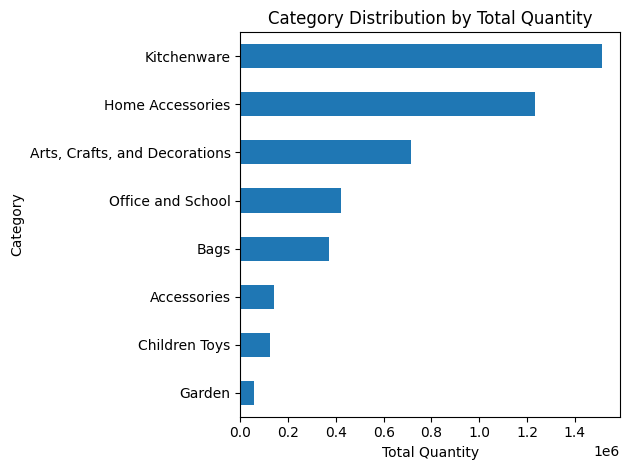

In [13]:
# Group by 'Category' and sum the 'Quantity'
category_distribution = df.groupby('Category')['Quantity'].sum().sort_values(ascending=True)

# Plotting the category distribution
category_distribution.plot(kind='barh')
plt.title('Category Distribution by Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


In [ ]:
# # Group by Category and calculate the size of each group

# category_sizes = df.groupby('Category').size()
# category_sizes_sorted = category_sizes.sort_values(ascending=True)
# category_sizes_sorted.plot(kind='barh')

# plt.title('Product Category Distribution')
# plt.xlabel('Count')
# plt.ylabel('Category')
# plt.show();

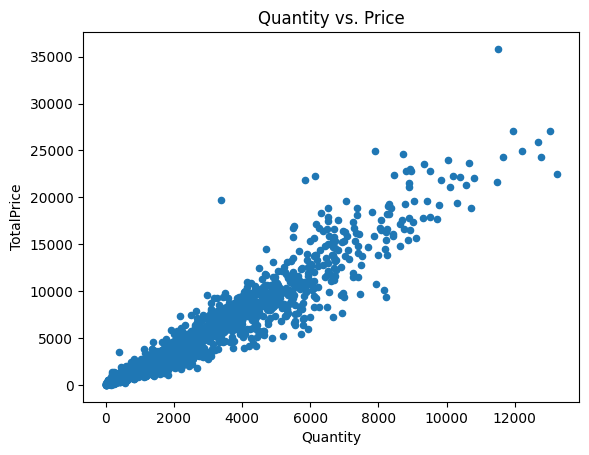

In [14]:
# # Plot the relationship between Quantity and TotalPrice

df.plot(kind='scatter', x='Quantity', y='TotalPrice')
plt.title('Quantity vs. Price')
plt.xlabel('Quantity')
plt.ylabel('TotalPrice')
plt.show();

Overall, the plot shows that there is a strong positive relationship between the number of sold products and the total price, and that this relationship is consistent across the data.

The range of total prices in the data is relatively narrow, indicating that the majority of the data points are concentrated in a relatively small range of total prices.

Let's take a look at the Distribution of Quantity and Total Price.

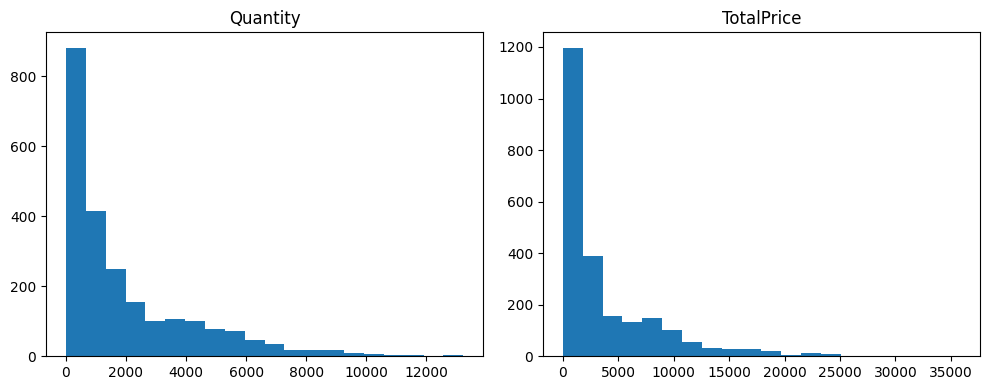

In [15]:
def plot_histograms(df, column1, column2, bins=20):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot histogram for column1
    df.hist(column1, bins=bins, ax=axes[0])
    axes[0].set_title(column1)
    axes[0].grid(False)
    
    # Plot histogram for column2
    df.hist(column2, bins=bins, ax=axes[1])
    axes[1].set_title(column2)
    axes[1].grid(False)
    
    plt.tight_layout()
    plt.show();

plot_histograms(df, 'Quantity', 'TotalPrice')

As we can see, the Quantity and TotalPrice columns are highly right-skewed. We transform them using Log Transformation.

In [ ]:
data = pd.read_csv('final_df.csv')
data.head()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the dataset
# Assuming the dataset is stored in a CSV file named 'sales_data.csv'
data = pd.read_csv('final_df.csv')

# Convert the 'transaction_date' column to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Set 'transaction_date' as the index
data.set_index('InvoiceDate', inplace=True)

# Resample the data to a monthly frequency
monthly_data = data.resample('D').sum()  # Aggregate monthly sales

# Decompose the time series to identify seasonality and trend
decomposition = sm.tsa.seasonal_decompose(monthly_data['Quantity'])

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(monthly_data['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [16]:
# One-hot encode the categorical columns and log transform the skewed columns
# Specify columns to encode and transform
#encode_cols = ['Category']

# Initialize and apply encoding
df = encode_categorical(df)
df.dropna(inplace=True)
df.head()

,Quantity,TotalPrice,Year,Month,Day,Diff,lag1,lag2,lag3,lag4,...,lag6,lag7,lag14,"Category_Arts, Crafts, and Decorations",Category_Bags,Category_Children Toys,Category_Garden,Category_Home Accessories,Category_Kitchenware,Category_Office and School
0,47,80.71,2010,12,19,-580.0,-538.0,198.0,10.0,379.0,...,-393.0,157.0,-492.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,546,682.49,2010,12,19,-1852.0,-833.0,-464.0,369.0,298.0,...,-1476.0,704.0,-174.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32,82.30,2010,12,19,-549.0,-625.0,494.0,-375.0,472.0,...,-1173.0,905.0,-168.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,101,133.35,2010,12,19,-950.0,564.0,167.0,-192.0,171.0,...,-142.0,150.0,157.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,26.55,2010,12,19,-174.0,115.0,-113.0,116.0,17.0,...,34.0,-124.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Plot the distribution of the Log transformed columns
#plot_histograms(df, 'Quantity_log', 'TotalPrice_log')

In [ ]:
# Plot highly correlated features

# Select only numeric columns for correlation calculation
numeric_columns = df.select_dtypes(include=['int32', 'int64', 'float64'])
#numeric_columns = numeric_columns.loc[:, ~numeric_columns.columns.str.startswith('lag')]

# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show();

**Columns to Remove:**

* RollingMeanMonth
* Holiday
* Weekend

In [ ]:
# columns_to_remove = ['Year', 'Weekend', 'Holiday', 'RollingMeanMonth']
# df = df.drop(columns=columns_to_remove, errors='ignore')
# print(df.shape)
# df.head()

## Model Building

### Split 

In [17]:
# Split into X and y
X = df.drop(columns=['Quantity'])
y = df['Quantity']

# Split into train and test based on date
# train_mask = (X['Month'] <= 9)  # Jan to Sep
# test_mask = (X['Month'] >= 10)  # Oct to Dec

train_mask = (X['Year'] < 2011) | ((X['Year'] == 2011) & (X['Month'] < 10)) # Dec 2010 to Sep 2011
test_mask = (X['Year'] == 2011) & (X['Month'] >= 10) # Oct 2011 to Dec 2011

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Drop 'InvoiceDate' column from X_train and X_test
# X_train = X_train.drop('InvoiceDate', axis=1)
# X_test = X_test.drop('InvoiceDate', axis=1)


# Displaying shapes of the splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Print split percentage and shape
train_percentage = len(X_train) / len(df) * 100
test_percentage = len(X_test) / len(df) * 100

print(f"Train set percentage: {train_percentage:.2f}%")
print(f"Test set percentage: {test_percentage:.2f}%")

X_train shape: (1840, 20)
y_train shape: (1840,)
X_test shape: (480, 20)
y_test shape: (480,)
Train set percentage: 79.31%
Test set percentage: 20.69%


### Scale Data

In [ ]:
df.head()

In [ ]:
X_test.head()

In [ ]:
X_train.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and X_test and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Convert the scaled array back to a DataFrame
#X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


### Baseline Model

In [18]:
# NOT SCALED DATA
# Initialize the LinearRegression model as a baseline
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE)
rmse_not_scaled = np.sqrt(mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error (RMSE):", rmse_not_scaled)

Root Mean Squared Error (RMSE): 847.6710599083375


In [ ]:
# # Initialize the LinearRegression model as a baseline
# baseline = LinearRegression()
# baseline.fit(X_train_scaled, y_train)
# y_pred = baseline.predict(X_test_scaled)

# # Calculate the Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print("Root Mean Squared Error (RMSE):", rmse)


### Train Models

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# class DemandPredictor:
#     def __init__(self):
#         self.models = {
#             'RandomForest': RandomForestRegressor(),
#             'XGBoost': XGBRegressor(),
#             'GradientBoosting': GradientBoostingRegressor()
#         }

#     def train(self, X_train, y_train):
#         trained_models = {}
#         for name, model in self.models.items():
#             model.fit(X_train, y_train)  # Fit the model
#             trained_models[name] = model
#         return trained_models

#     def predict(self, trained_models, X_test, y_test):
#         predictions = {}
#         scores = {}
#         for name, model in trained_models.items():
#             y_pred = model.predict(X_test)  # Predict using each trained model
#             predictions[name] = y_pred
#             mae = mean_absolute_error(y_test, y_pred)
#             mse = mean_squared_error(y_test, y_pred)
#             rmse = np.sqrt(mse)
#             r2 = r2_score(y_test, y_pred)
#             scores[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r2}
#         return predictions, scores


In [22]:
class DemandPredictor:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(),
            'XGBoost': XGBRegressor(),
            'GradientBoosting': GradientBoostingRegressor()
        }

    def train(self, X_train, y_train):
        trained_models = {}
        for name, model in self.models.items():
            model.fit(X_train, y_train)  # Fit the model
            trained_models[name] = model
        return trained_models

    def predict(self, trained_models, X_test, y_test):
        predictions = {}
        scores = {}
        for name, model in trained_models.items():
            y_pred = model.predict(X_test)  # Predict using each trained model
            predictions[name] = y_pred
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            scores[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r2}
        return predictions, scores

    def get_scores(self, X_test, y_test):
        _, scores = self.predict(self.models, X_test, y_test)
        return scores


In [23]:
# NOT SCALED
# Initialize the DemandPredictor class
demand_predictor = DemandPredictor()

# Train the models
trained_models = demand_predictor.train(X_train, y_train)

# Make predictions
predictions, scores = demand_predictor.predict(trained_models, X_test, y_test)

# Print model scores
for name, score in scores.items():
    print(f"Model: {name}")
    print(f"MAE: {score['MAE']}")
    print(f"MSE: {score['MSE']}")
    print(f"RMSE: {score['RMSE']}")
    print(f"R^2: {score['R^2']}")
    print()

Model: RandomForest
MAE: 491.5426666666668
MSE: 616832.5228333335
RMSE: 785.3868618924902
R^2: 0.9250880835634913

Model: XGBoost
MAE: 509.9867274641991
MSE: 730109.8659444224
RMSE: 854.4646662937107
R^2: 0.9113309897865465

Model: GradientBoosting
MAE: 514.9176838059689
MSE: 663974.3389955898
RMSE: 814.8462057318484
R^2: 0.9193628929124037



In [ ]:
# # Initialize the DemandPredictor class
# demand_predictor = DemandPredictor()

# # Train the models
# trained_models = demand_predictor.train(X_train_scaled, y_train)

# # Make predictions
# predictions, scores = demand_predictor.predict(trained_models, X_test_scaled, y_test)

# # Print model scores
# for name, score in scores.items():
#     print(f"Model: {name}")
#     print(f"MAE: {score['MAE']}")
#     print(f"MSE: {score['MSE']}")
#     print(f"RMSE: {score['RMSE']}")
#     print(f"R^2: {score['R^2']}")
#     print()

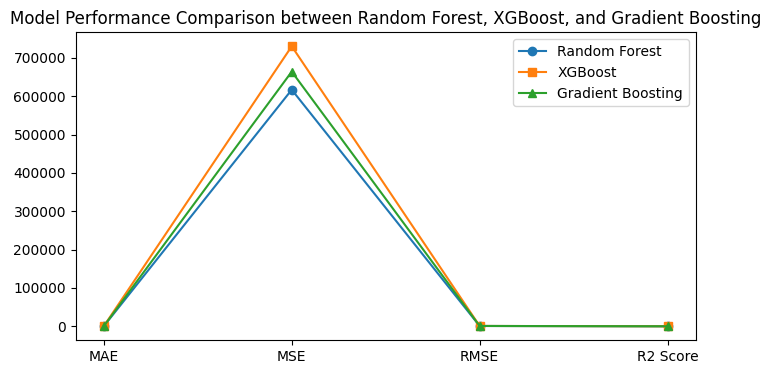

In [24]:
# Extract the performance metrics for each model
rf_stats = [scores['RandomForest']['MAE'], scores['RandomForest']['MSE'], scores['RandomForest']['RMSE'], scores['RandomForest']['R^2']]
xgb_stats = [scores['XGBoost']['MAE'], scores['XGBoost']['MSE'], scores['XGBoost']['RMSE'], scores['XGBoost']['R^2']]
gb_stats = [scores['GradientBoosting']['MAE'], scores['GradientBoosting']['MSE'], scores['GradientBoosting']['RMSE'], scores['GradientBoosting']['R^2']]

# Plot the performance metrics
plt.figure(figsize=(8, 4))
plt.plot(rf_stats, marker='o')  # Random Forest
plt.plot(xgb_stats, marker='s')  # XGBoost
plt.plot(gb_stats, marker='^')  # Gradient Boosting

# Set title and labels
plt.title("Model Performance Comparison between Random Forest, XGBoost, and Gradient Boosting")
plt.xticks([0, 1, 2, 3], labels=['MAE', 'MSE', 'RMSE', 'R2 Score'])
plt.legend(["Random Forest", "XGBoost", "Gradient Boosting"])

# Show the plot
plt.show()


From the comparison curves, Gradient Boosting performs overall best closely followed by XGBoost. Random Forest seems a little bit off compared to other models but its performance can be tuned using hyperparameter optimization.

We go with the Gradient Boosting model and tune hyperparameters to get better results.

In [25]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [27]:
# class GBMTrainer:
#     def __init__(self, checkpoint_path=None):
#         # Initialize model as GradientBoostingRegressor
#         self.model = GradientBoostingRegressor(random_state=42)
        
#         # Define parameter grid
#         self.param_grid = {
#             'n_estimators': [100, 200, 300],
#             'learning_rate': [0.01, 0.1, 0.5],
#             'max_depth': [3, 5, 7]
#         }
        
#         # Set the checkpoint path
#         self.checkpoint_path = checkpoint_path
    
#     def train(self, X_train, y_train, filename='gbm.joblib'):
#         # Define custom scoring function for MAE, MSE, RMSE, and R2 Score
#         mae_scorer = make_scorer(mean_absolute_error)
#         mse_scorer = make_scorer(mean_squared_error)
#         rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
#         r2_scorer = make_scorer(r2_score)
        
#         # Initialize GridSearchCV with custom scoring for MAE, MSE, RMSE, and R2 Score
#         grid_search = GridSearchCV(estimator=self.model, param_grid=self.param_grid,
#                                    cv=5, scoring={'mae': mae_scorer, 'mse': mse_scorer, 'rmse': rmse_scorer, 'r2': r2_scorer}, 
#                                    verbose=1, refit='rmse', n_jobs=-1)
        
#         # Fit GridSearchCV
#         grid_search.fit(X_train, y_train)
        
#         # Save best model checkpoint
#         if self.checkpoint_path:
#             joblib.dump(grid_search.best_estimator_, self.checkpoint_path)

#         # Save the best model along with its best parameters
#         best_model_filename = f"{filename.split('.')[0]}_best_model.joblib"
#         joblib.dump((grid_search.best_estimator_, grid_search.best_params_), best_model_filename)
        
#         # Update model attribute with best estimator
#         self.model = grid_search.best_estimator_
        
#         # Return best model, best parameters, and evaluation metrics
#         return self.model, grid_search.best_params_, grid_search.cv_results_

#     def predict(self, X):
#         # Make predictions using the trained model
#         return self.model.predict(X)

class GBRTrainer:
     def __init__(self, checkpoint_path=None):
         self.model = GradientBoostingRegressor(random_state=42)
         self.param_grid = {
             'n_estimators': [100, 200, 300],
             'learning_rate': [0.01, 0.1, 0.5],
             'max_depth': [3, 5, 7]
         }
         self.checkpoint_path = checkpoint_path

     def train(self, X_train, y_train, filename='gbr.joblib'):
         # Initialize GridSearchCV
         grid_search = GridSearchCV(estimator=self.model, param_grid=self.param_grid,
                                    cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
         # Fit GridSearchCV
         grid_search.fit(X_train, y_train)
         # Save best model checkpoint
         if self.checkpoint_path:
             joblib.dump(grid_search.best_estimator_, self.checkpoint_path)
         
         # Save the best model along with its best parameters
         best_model_filename = f"{filename.split('.')[0]}_best_model.joblib"
         joblib.dump((grid_search.best_estimator_, grid_search.best_params_), best_model_filename)
         # Update model attribute with best estimator
         self.model = grid_search.best_estimator_
         # Return best model, best parameters, and best RMSE
         return self.model, grid_search.best_params_, np.sqrt(-grid_search.best_score_)


# Initialize the GBMTrainer
trainer = GBRTrainer()

# Train the model
best_model, best_params, cv_results = trainer.train(X_train, y_train)

# Print the best parameters
print("Best Parameters:", best_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# import joblib

# class GradientBoostingModelTrainer:
#     def __init__(self, params=None, cv=5):
#         if params is None:
#             # Default parameters for GradientBoostingRegressor
#             self.params = {
#                 'n_estimators': [100, 200, 300],
#                 'learning_rate': [0.01, 0.1, 0.5],
#                 'max_depth': [3, 5, 7]
#             }
#         else:
#             self.params = params
#         self.cv = cv

#     def train(self, X_train, y_train, X_test, y_test, filename='best_gbr_model.joblib'):
#         # Initialize GradientBoostingRegressor
#         gbr = GradientBoostingRegressor()
        
#         # GridSearchCV to find the best parameters
#         grid_search = GridSearchCV(gbr, self.params, cv=self.cv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
#         grid_search.fit(X_train, y_train)
        
#         # Get the best model
#         best_model = grid_search.best_estimator_
        
#         # Save the best model along with its best parameters
#         joblib.dump((best_model, grid_search.best_params_), filename)
        
#         # Make predictions with the best model
#         predictions = best_model.predict(X_test)
        
#         # Calculate metrics
#         mae = mean_absolute_error(y_test, predictions)
#         mse = mean_squared_error(y_test, predictions)
#         rmse = np.sqrt(mse)
#         r2 = r2_score(y_test, predictions)
        
#         return best_model, grid_search.best_params_, mae, mse, rmse, r2


In [ ]:
# Import GradientBoostingModelTrainer into your script
from modeling import GradientBoostingModelTrainer

# Load the tuple containing the best model and its best parameters
loaded_tuple = joblib.load('best_gbr_model.joblib')

# Extract the best model and its best parameters from the loaded tuple
best_model, best_params = loaded_tuple

# Create an instance of GradientBoostingModelTrainer
trainer = GradientBoostingModelTrainer(params=best_params)

# Train the model and calculate metrics
best_model, best_params, mae, mse, rmse, r2 = trainer.train(X_train, y_train, X_test, y_test)

# Print the metrics
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

In [ ]:
best_model

In [ ]:
trainer = GradientBoostingModelTrainer()
best_model, best_params = trainer.train(X_train, y_train, X_test, y_test)

# Initialize GBRModel with the best parameters
model = GBRModel(params=best_params)

# Train the model and save it
mae, mse, rmse, r2 = model.train(X_train, y_train, X_test, y_test)


In [ ]:
best_params

In [ ]:
import matplotlib.pyplot as plt

# Exclude the most important feature
top_feature_names = top_feature_names[1:]
top_feature_importances = top_feature_importances[2:] # Select starting from the 3rd important

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_feature_names)), top_feature_importances, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Excluding Most Important Feature)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()



In [28]:
# Save the model object and params and metrics separately (not as a tuple)
import joblib
import json

class GBRModel:
    def __init__(self, params=None): # params=best_params
        if params is None:
            # Default parameters for GradientBoostingRegressor
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        
        # Initialize GradientBoostingRegressor with the provided parameters
        self.model = GradientBoostingRegressor(**self.params)
        self.metrics = {}

    def train(self, X_train, y_train, X_test, y_test, model_filename='gbr_model.joblib', metrics_filename='metrics.json'):
        # Train the model
        self.model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = self.model.predict(X_test)
        
        # Calculate evaluation metrics
        self.metrics['mae'] = mean_absolute_error(y_test, y_pred)
        self.metrics['mse'] = mean_squared_error(y_test, y_pred)
        self.metrics['rmse'] = np.sqrt(self.metrics['mse'])
        self.metrics['r2'] = r2_score(y_test, y_pred)
        
        # Save the trained model object
        joblib.dump(self.model, model_filename)
        
        # Save the metrics as a JSON file
        with open(metrics_filename, 'w') as f:
            json.dump(self.metrics, f)
        
        return self.metrics

    def predict(self, X):
        return self.model.predict(X)

    def load_model(self, model_filename):
        # Load the trained model object
        self.model = joblib.load(model_filename)

    def load_metrics(self, metrics_filename):
        # Load the evaluation metrics from JSON file
        with open(metrics_filename, 'r') as f:
            self.metrics = json.load(f)



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

from sklearn.ensemble import GradientBoostingRegressor

class GBRModel:
    def __init__(self, params=None): # params=best_params
        if params is None:
            # Default parameters for GradientBoostingRegressor
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        
        # Initialize GradientBoostingRegressor with the provided parameters
        self.model = GradientBoostingRegressor(**self.params)

    def train(self, X_train, y_train, X_test, y_test, filename='gbr_model.joblib'):
        # Train the model
        self.model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = self.model.predict(X_test)
        
        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Save the trained model along with its evaluation metrics
        joblib.dump((self.model, {'params': self.params, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}), filename)
        
        return mae, mse, rmse, r2

    def predict(self, X):
        return self.model.predict(X)


In [ ]:
# If tuple error is returned

# Load the saved model
model_tuple = joblib.load(model_path)

# Extract the trained model object from the tuple
model = model_tuple[0]  # The first element of the tuple is the model object

# Now you can use the trained model object for prediction
predictions = model.predict(X_test)  # Example prediction

# Optionally, you can also access other metadata from the tuple if needed
metadata = model_tuple[1]
params = metadata['params']
mae = metadata['mae']
mse = metadata['mse']
rmse = metadata['rmse']
r2 = metadata['r2']


In [32]:
# Initialize the trainer
gbr_model = GBRModel()
gbr_model.load_model(model_filename='gbr_model.joblib')
gbr_model.load_metrics(metrics_filename='metrics.json')


# Train the model and calculate metrics
metrics = gbr_model.train(X_train, y_train, X_test, y_test)

# Print the calculated metrics
print("MAE:", metrics['mae'])
print("MSE:", metrics['mse'])
print("RMSE:", metrics['rmse'])
print("R2 Score:", metrics['r2'])

MAE: 518.2854970658249
MSE: 655151.7721446673
RMSE: 809.4144625250202
R2 Score: 0.9204343594227232


In [ ]:
# Save dates of X_test as a list to append to the predictions df
dates = (df[['InvoiceDate']][(pd.to_datetime(df['InvoiceDate'])
                             .dt.month >= 10)].rename(columns={"InvoiceDate": "Date"})
                             .reset_index(drop=True)['Date']
                             .values.tolist())

In [ ]:
len(dates)

In [33]:
def make_predictions(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Add the 'Category' from the one-hot encoded columns in X_test
    categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
    
    # Create a DataFrame to store results
    results = {
        #'Date': [date.strftime('%Y-%m-%d') for date in dates],
        # Combine the columns into a list of dates
        'Date': [f"{year}-{month:02d}-{day:02d}" for year, month, day in zip(X_test['Year'], X_test['Month'], X_test['Day'])],
        'Category': categories,
        'Actual': y_test,
        'Predicted': y_pred.astype(int)
    }
  
    return results

# Call the function to make predictions
predictions_df = pd.DataFrame(make_predictions(gbr_model, X_test, y_test)).reset_index(drop=True)
predictions_df.head()

,Date,Category,Actual,Predicted
0,2011-10-02,Accessories,453,332
1,2011-10-02,"Arts, Crafts, and Decorations",1461,1368
2,2011-10-02,Bags,206,30
3,2011-10-02,Children Toys,99,151
4,2011-10-02,Garden,27,57


In [ ]:
len(predictions_df)

In [ ]:
predictions_df.groupby([predictions_df['Category']]).agg({
            'Predicted': 'sum',          # Sum of predicted
            }).reset_index()

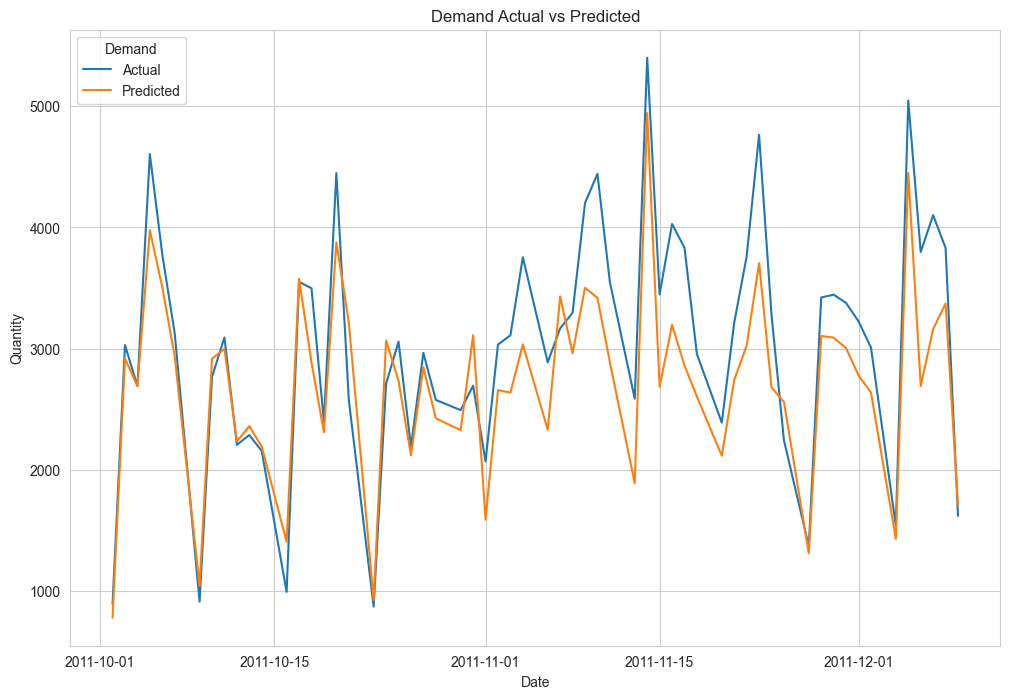

In [35]:
def plot_predictions(results):
    # Set style
    sns.set_style("whitegrid")
    
    # Line plot of actual vs predicted values
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=results, x='Date', y='Actual', label='Actual', ci=None)
    sns.lineplot(data=results, x='Date', y='Predicted', label='Predicted', ci=None)
    plt.title('Demand Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    #plt.xticks(rotation=45)
    
    plt.legend(title='Demand')
    #plt.tight_layout()
    plt.show()
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
plot_predictions(predictions_df)

The model made predictions for the test set. Now let's modify the `GBRModel` to predict next 14 days.

In [46]:
# with saving as joblib

class GBRegressor:
    def __init__(self, params=None):
        if params is None:
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        
        self.model = GradientBoostingRegressor(**self.params)
    
    def train(self, X, y, model_filename='gbr_model_14.joblib'):
        self.model.fit(X, y)
        joblib.dump(self.model, model_filename)  # Save the trained model as a joblib file
        
    def predict(self, X):
        return self.model.predict(X)

    def make_future_predictions(self, X, start_date):
        future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, 15)]
        
        category_cols = [col for col in X.columns if col.startswith('Category_')]
        categories = []
        for idx in range(X.shape[0]):
            row = X.iloc[idx][category_cols]
            if row.sum() == 0:
                categories.append('Accessories')
            else:
                categories.append(row.idxmax().replace('Category_', ''))

        unique_categories = list(set(categories))
        results = []
        
        for category in unique_categories:
            if category == 'Accessories':
                category_X = X[(X[category_cols].sum(axis=1) == 0)]
            else:
                category_X = X[(X[category_cols].idxmax(axis=1) == f"Category_{category}")]
            
            future_predictions = self.predict(category_X)
            
            for i, date in enumerate(future_dates):
                results.append({
                    'Date': date,
                    'Category': category,
                    'Predicted': future_predictions[i].astype(int)
                })
        return results


In [48]:
# Initialize GBRegressor with default or specified parameters
gb_regressor = GBRegressor(params=best_params)

# Train the model
gb_regressor.train(X_train, y_train)

# Predict the next 14 days
dates = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
last_date = dates.max()

categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1).unique()
predictions = gb_regressor.make_future_predictions(X_test, last_date)

# Convert predictions to a DataFrame
new_predictions_df = pd.DataFrame(predictions)
new_predictions_df

,Date,Category,Predicted
0,2011-12-10,Kitchenware,1568
1,2011-12-11,Kitchenware,6574
2,2011-12-12,Kitchenware,5530
3,2011-12-13,Kitchenware,11957
4,2011-12-14,Kitchenware,6873
...,...,...,...
107,2011-12-19,"Arts, Crafts, and Decorations",4936
108,2011-12-20,"Arts, Crafts, and Decorations",900
109,2011-12-21,"Arts, Crafts, and Decorations",3754
110,2011-12-22,"Arts, Crafts, and Decorations",239


In [96]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

class GBRegressor:
    def __init__(self, params=None):
        if params is None:
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        
        self.model = GradientBoostingRegressor(**self.params)
    
    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def make_future_predictions(self, X, start_date):
        future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, 15)]
        
        category_cols = [col for col in X.columns if col.startswith('Category_')]
        categories = []
        for idx in range(X.shape[0]):
            row = X.iloc[idx][category_cols]
            if row.sum() == 0:
                categories.append('Accessories')
            else:
                categories.append(row.idxmax().replace('Category_', ''))

        unique_categories = list(set(categories))
        results = []
        
        for category in unique_categories:
            if category == 'Accessories':
                category_X = X[(X[category_cols].sum(axis=1) == 0)]
            else:
                category_X = X[(X[category_cols].idxmax(axis=1) == f"Category_{category}")]
            
            future_predictions = self.predict(category_X)

            for i, date in enumerate(future_dates):
                results.append({
                    'Date': date,
                    'Category': category,
                    'Predicted': future_predictions[i].astype(int)
                })
        return results

    # def make_future_predictions(self, X, start_date):
    #     future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, 15)]
        
    #     category_cols = [col for col in X.columns if col.startswith('Category_')]
    #     categories = []
    #     for idx in range(X.shape[0]):
    #         row = X.iloc[idx][category_cols]
    #         if row.sum() == 0:
    #             categories.append('Accessories')
    #         else:
    #             categories.append(row.idxmax().replace('Category_', ''))

    #     unique_categories = list(set(categories))
    #     results = []
        
    #     for category in unique_categories:
    #         if category == 'Accessories':
    #             category_X = X[(X[category_cols].sum(axis=1) == 0)]
    #         else:
    #             category_X = X[(X[category_cols].idxmax(axis=1) == f"Category_{category}")]
            
    #         future_predictions = self.predict(category_X)
    #         total_future_predictions = sum(future_predictions[:14])  # Sum the first 14 predictions
            
    #         results.append({
    #             'Date': future_dates[-1],  # Last date in the prediction period
    #             'Category': category,
    #             'Predicted': total_future_predictions.astype(int)
    #         })
    #     return results



# Initialize GBRegressor with default or specified parameters
gb_regressor = GBRegressor(params=best_params)

# Train the model
gb_regressor.train(X_train, y_train)

# Predict the next 14 days
dates = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
last_date = dates.max()

categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1).unique()
predictions = gb_regressor.make_future_predictions(X_test, last_date)

# Convert predictions to a DataFrame
new_predictions_df = pd.DataFrame(predictions)
new_predictions_df


,Date,Category,Predicted
0,2011-12-10,Kitchenware,1568
1,2011-12-11,Kitchenware,6574
2,2011-12-12,Kitchenware,5530
3,2011-12-13,Kitchenware,11940
4,2011-12-14,Kitchenware,6928
...,...,...,...
107,2011-12-19,"Arts, Crafts, and Decorations",4936
108,2011-12-20,"Arts, Crafts, and Decorations",900
109,2011-12-21,"Arts, Crafts, and Decorations",3754
110,2011-12-22,"Arts, Crafts, and Decorations",239


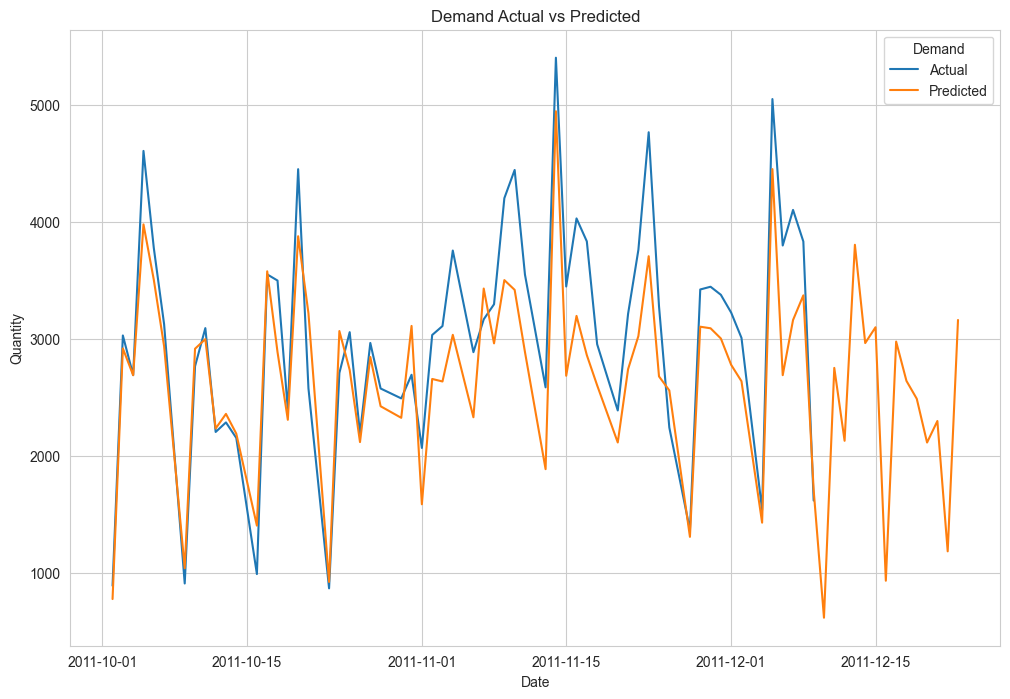

In [37]:
# Plot the test set and 14 days ahed predictions
# Merge the two predictions df
merged_df = pd.concat([predictions_df, new_predictions_df], ignore_index=True)
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

plot_predictions(merged_df)

In [95]:
dd = pd.read_csv('C:/Users/madinah/Desktop/inputs/inputs-dec.csv')
dd_feat = extractor.derive_features(dd)
dd_enc = encode_categorical(dd_feat)
dd_enc.dropna(inplace=True)
dd_enc.drop(columns=['Quantity'], inplace=True)

# Predict the next 14 days
dd_dates = pd.to_datetime(dd_enc[['Year', 'Month', 'Day']])
dd_last_date = dd_dates.max()

categories = dd_enc.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1).unique()
pred_dd = gb_regressor.make_future_predictions(dd_enc, dd_last_date)

# Convert predictions to a DataFrame
new_pred_dd = pd.DataFrame(pred_dd)
new_pred_dd

IndexError: index 3 is out of bounds for axis 0 with size 3

In [92]:
dd_last_date

Timestamp('2011-12-21 00:00:00')

In [88]:
max(dd['InvoiceDate'])

'2011-12-21'

In [90]:
dd_dates

0    2011-12-19
1    2011-12-19
2    2011-12-19
3    2011-12-19
4    2011-12-19
5    2011-12-19
6    2011-12-19
7    2011-12-19
8    2011-12-20
9    2011-12-20
10   2011-12-20
11   2011-12-20
12   2011-12-20
13   2011-12-20
14   2011-12-20
15   2011-12-20
16   2011-12-21
17   2011-12-21
18   2011-12-21
19   2011-12-21
20   2011-12-21
21   2011-12-21
22   2011-12-21
23   2011-12-21
dtype: datetime64[ns]

In [89]:
dd_enc

,TotalPrice,Year,Month,Day,Diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag14,"Category_Arts, Crafts, and Decorations",Category_Bags,Category_Children Toys,Category_Garden,Category_Home Accessories,Category_Kitchenware,Category_Office and School
0,80.71,2011,12,19,-459.0,-218.0,-138.0,100.0,290.0,162.0,-247.0,57.0,-618.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,431.09,2011,12,19,-1229.0,-52.0,-745.0,179.0,463.0,439.0,-1257.0,1072.0,-130.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59.10,2011,12,19,-351.0,-120.0,-21.0,-122.0,298.0,238.0,-979.0,754.0,61.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,90.60,2011,12,19,-642.0,428.0,50.0,-79.0,92.0,-107.0,-42.0,43.0,280.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,26.55,2011,12,19,-153.0,100.0,-71.0,71.0,23.0,-65.0,53.0,-116.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1547.57,2011,12,19,-954.0,-2216.0,1940.0,-838.0,-125.0,1402.0,-2195.0,1529.0,923.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2782.30,2011,12,19,-2510.0,-194.0,1090.0,-1674.0,1227.0,1723.0,-2872.0,1437.0,-1133.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,284.52,2011,12,19,-525.0,-280.0,372.0,-324.0,98.0,291.0,-348.0,89.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,876.84,2011,12,20,524.0,-459.0,-218.0,-138.0,100.0,290.0,162.0,-247.0,-56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1285.16,2011,12,20,706.0,-1229.0,-52.0,-745.0,179.0,463.0,439.0,-1257.0,-616.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
data_dict = [{'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.85,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 4.95,
  'Category': 'Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 5.95,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 3.39,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 18,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.69,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 0.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 11,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 7.65,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 3.75,
  'Category': 'Children Toys'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 2.55,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 4.25,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 7.95,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 3.39,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 2.1,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.65,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 58,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-01',
  'UnitPrice': 1.25,
  'Category': 'Office and School'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.85,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 2.1,
  'Category': 'Accessories'},
 {'Quantity': 48,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 0.85,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 3.39,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.69,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 8.95,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 7.65,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 2.95,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.95,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 2.95,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 4.25,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 3.75,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 16,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 0.85,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 8.5,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 2.1,
  'Category': 'Office and School'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-02',
  'UnitPrice': 3.95,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 2.1,
  'Category': 'Accessories'},
 {'Quantity': 5,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 48,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.42,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.42,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 2.55,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 29.95,
  'Category': 'Bags'},
 {'Quantity': 60,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.45,
  'Category': 'Children Toys'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.95,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 3.36,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 4.21,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 2.55,
  'Category': 'Home Accessories'},
 {'Quantity': 19,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 3.75,
  'Category': 'Home Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.45,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.65,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 4.25,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 1.25,
  'Category': 'Office and School'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-03',
  'UnitPrice': 8.5,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.1,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.25,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 5.95,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.75,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 80,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.55,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 0.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 4.25,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.75,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 1.65,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 11,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.55,
  'Category': 'Home Accessories'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 6.75,
  'Category': 'Home Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 7.95,
  'Category': 'Home Accessories'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 3.95,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 4.95,
  'Category': 'Kitchenware'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 4.65,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 4.95,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-05',
  'UnitPrice': 1.65,
  'Category': 'Office and School'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 5.95,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 2.1,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 12.72,
  'Category': 'Accessories'},
 {'Quantity': 25,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 0.42,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 2.1,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 1.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 0.84,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 4.21,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 4.21,
  'Category': 'Bags'},
 {'Quantity': 156,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 8.5,
  'Category': 'Children Toys'},
 {'Quantity': 216,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 1.06,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 7.62,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 5.91,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 7.62,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 2.95,
  'Category': 'Home Accessories'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 2.1,
  'Category': 'Home Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 8.5,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 1.65,
  'Category': 'Kitchenware'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 5.49,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 2.55,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 5.55,
  'Category': 'Office and School'},
 {'Quantity': 288,
  'InvoiceDate': '2011-12-06',
  'UnitPrice': 1.06,
  'Category': 'Office and School'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 1.69,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.1,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 3.25,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 4.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 40,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.55,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 4.25,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.25,
  'Category': 'Bags'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 0.85,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 1.45,
  'Category': 'Children Toys'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 5.95,
  'Category': 'Children Toys'},
 {'Quantity': 5,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.95,
  'Category': 'Garden'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 1.25,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.1,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.1,
  'Category': 'Home Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 4.25,
  'Category': 'Home Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 5.95,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 5.49,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 5.95,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 16,
  'InvoiceDate': '2011-12-07',
  'UnitPrice': 3.75,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.25,
  'Category': 'Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 6.75,
  'Category': 'Accessories'},
 {'Quantity': 25,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 128,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 2.55,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 3.39,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 0.85,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 50,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 25,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.95,
  'Category': 'Garden'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 2.1,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.45,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.45,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 4.25,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 3.39,
  'Category': 'Office and School'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-08',
  'UnitPrice': 6.45,
  'Category': 'Office and School'},
 {'Quantity': 18,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.95,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.95,
  'Category': 'Accessories'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 72,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 4.95,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.65,
  'Category': 'Children Toys'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 12.75,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.1,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.55,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 7.95,
  'Category': 'Home Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 7.95,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 3.95,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 4.65,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 5.55,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-09',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 12.72,
  'Category': 'Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 12.72,
  'Category': 'Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.66,
  'Category': 'Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 0.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 18,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.25,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 4.21,
  'Category': 'Bags'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.66,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 8.5,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.45,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 5.06,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 7.62,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 4.21,
  'Category': 'Garden'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 4.95,
  'Category': 'Home Accessories'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.1,
  'Category': 'Home Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.25,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 0.55,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 60,
  'InvoiceDate': '2011-12-10',
  'UnitPrice': 0.21,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 4.25,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 0.85,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 2.95,
  'Category': 'Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 3.75,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 2.55,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 5.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 0.95,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.25,
  'Category': 'Bags'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.65,
  'Category': 'Children Toys'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 2.95,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 2.95,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 30,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.65,
  'Category': 'Garden'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.65,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 5.95,
  'Category': 'Home Accessories'},
 {'Quantity': 5,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 1.65,
  'Category': 'Home Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 4.25,
  'Category': 'Kitchenware'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 4.95,
  'Category': 'Kitchenware'},
 {'Quantity': 5,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 4.65,
  'Category': 'Kitchenware'},
 {'Quantity': 15,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 7.65,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 0.42,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-12',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 5.95,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.51,
  'Category': 'Accessories'},
 {'Quantity': 17,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 0.43,
  'Category': 'Accessories'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 12.75,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 64,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.1,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.95,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 4.21,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 4.21,
  'Category': 'Bags'},
 {'Quantity': 5,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 7.95,
  'Category': 'Children Toys'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 5.91,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 4.21,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.51,
  'Category': 'Garden'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 3.75,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 4.95,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 1.65,
  'Category': 'Home Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 5.95,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 3.75,
  'Category': 'Kitchenware'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 16.95,
  'Category': 'Kitchenware'},
 {'Quantity': 48,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 2.1,
  'Category': 'Office and School'},
 {'Quantity': 48,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 3.39,
  'Category': 'Office and School'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-13',
  'UnitPrice': 3.75,
  'Category': 'Office and School'},
 {'Quantity': 20,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 1.69,
  'Category': 'Accessories'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 1.45,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 48,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 0.42,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 3.35,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 4.95,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.95,
  'Category': 'Children Toys'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 6.75,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 9.95,
  'Category': 'Garden'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.55,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 4.95,
  'Category': 'Home Accessories'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 3.95,
  'Category': 'Home Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 15.0,
  'Category': 'Kitchenware'},
 {'Quantity': 96,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 50,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 4.65,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-14',
  'UnitPrice': 6.45,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 20,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 60,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.19,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 8.95,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 2.1,
  'Category': 'Bags'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.95,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 3.75,
  'Category': 'Garden'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.95,
  'Category': 'Garden'},
 {'Quantity': 20,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 2.95,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 60,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.21,
  'Category': 'Home Accessories'},
 {'Quantity': 20,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 2.95,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 2.1,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.19,
  'Category': 'Kitchenware'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.42,
  'Category': 'Office and School'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 0.21,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-15',
  'UnitPrice': 1.25,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.65,
  'Category': 'Accessories'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.21,
  'Category': 'Accessories'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.42,
  'Category': 'Accessories'},
 {'Quantity': 30,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 3.39,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 5.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 40,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.55,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 30,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 30,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 50,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 15,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.1,
  'Category': 'Children Toys'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.95,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.55,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.85,
  'Category': 'Garden'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 6.75,
  'Category': 'Home Accessories'},
 {'Quantity': 144,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.45,
  'Category': 'Home Accessories'},
 {'Quantity': 40,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 1.45,
  'Category': 'Home Accessories'},
 {'Quantity': 9,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 4.95,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.55,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.85,
  'Category': 'Kitchenware'},
 {'Quantity': 16,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 7.65,
  'Category': 'Office and School'},
 {'Quantity': 36,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 2.1,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-16',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 5.95,
  'Category': 'Accessories'},
 {'Quantity': 200,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.72,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.25,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.69,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 16,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 2.25,
  'Category': 'Bags'},
 {'Quantity': 192,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.65,
  'Category': 'Bags'},
 {'Quantity': 10,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 144,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.45,
  'Category': 'Children Toys'},
 {'Quantity': 192,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.85,
  'Category': 'Garden'},
 {'Quantity': 72,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.21,
  'Category': 'Garden'},
 {'Quantity': 16,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.85,
  'Category': 'Garden'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 4.95,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 3.95,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.42,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.85,
  'Category': 'Kitchenware'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 7.95,
  'Category': 'Kitchenware'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-17',
  'UnitPrice': 4.25,
  'Category': 'Office and School'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 1.65,
  'Category': 'Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Accessories'},
 {'Quantity': 25,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.42,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.85,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.95,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 4.95,
  'Category': 'Bags'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 7,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 3.75,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 5.95,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 6.75,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 1.95,
  'Category': 'Garden'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 1.25,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.1,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 7.95,
  'Category': 'Home Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 9.95,
  'Category': 'Kitchenware'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.95,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-19',
  'UnitPrice': 2.55,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 2.51,
  'Category': 'Accessories'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 6.77,
  'Category': 'Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 3.36,
  'Category': 'Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.65,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.43,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.95,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 2.1,
  'Category': 'Bags'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.42,
  'Category': 'Children Toys'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.65,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.85,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.66,
  'Category': 'Garden'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 2.51,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 11.87,
  'Category': 'Garden'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 4.95,
  'Category': 'Home Accessories'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.49,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 5.95,
  'Category': 'Home Accessories'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 3.75,
  'Category': 'Kitchenware'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 2.95,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 1.45,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.42,
  'Category': 'Office and School'},
 {'Quantity': 24,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.42,
  'Category': 'Office and School'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-20',
  'UnitPrice': 0.65,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 6.75,
  'Category': 'Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 4.95,
  'Category': 'Accessories'},
 {'Quantity': 8,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.69,
  'Category': 'Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 2.95,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 72,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.25,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 4,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 8.5,
  'Category': 'Arts, Crafts, and Decorations'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 2.95,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 4.25,
  'Category': 'Bags'},
 {'Quantity': 100,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.65,
  'Category': 'Bags'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 7.95,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.25,
  'Category': 'Children Toys'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 0.85,
  'Category': 'Children Toys'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 5.91,
  'Category': 'Garden'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 34.0,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 2.1,
  'Category': 'Garden'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 2.95,
  'Category': 'Home Accessories'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.65,
  'Category': 'Home Accessories'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.65,
  'Category': 'Home Accessories'},
 {'Quantity': 3,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 5.95,
  'Category': 'Kitchenware'},
 {'Quantity': 12,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.25,
  'Category': 'Kitchenware'},
 {'Quantity': 6,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 2.95,
  'Category': 'Kitchenware'},
 {'Quantity': 18,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 4.25,
  'Category': 'Office and School'},
 {'Quantity': 2,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 0.85,
  'Category': 'Office and School'},
 {'Quantity': 1,
  'InvoiceDate': '2011-12-21',
  'UnitPrice': 1.25,
  'Category': 'Office and School'}]

In [79]:
class GBRegressorApp:
    def __init__(self, model_path=None, params=None):
        if model_path:
            self.model = joblib.load(model_path)
        else:
            if params is None:
                self.params = {
                    'n_estimators': 300,
                    'learning_rate': 0.1,
                    'max_depth': 3
                }
            else:
                self.params = params
            self.model = GradientBoostingRegressor(**self.params)
    
    def derive_features(self, data_dict):
        #logger.info("Starting feature derivation")
        df = pd.DataFrame(data_dict)  # Convert input to DataFrame
        #logger.info(f"Initial DataFrame:\n{df.head()}")

        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
        df_agg = df.groupby(['InvoiceDate', 'Category']).agg({
            'Quantity': 'sum',
            'TotalPrice': 'sum'
        }).reset_index()

        df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')
        df_agg['Year'] = df_agg['InvoiceDate'].dt.year
        df_agg['Month'] = df_agg['InvoiceDate'].dt.month
        df_agg['Day'] = df_agg['InvoiceDate'].dt.day

        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)
        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']
        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        lag_columns = []
        for lag in range(1, 8):
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        for lag in range(7, 15, 7):
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        df_agg = df_agg.dropna().reset_index(drop=True)
        df_agg.rename(columns={'InvoiceDate': 'Date'}, inplace=True)
        
        #logger.info(f"Processed DataFrame:\n{df_agg.head()}")
        return df_agg

    def encode_categorical(self, df, encode_cols=None):
        if encode_cols is None:
            encode_cols = []
        if 'Category' not in encode_cols:
            encode_cols.append('Category')
        
        df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=float)
        #logger.info(f"Encoded DataFrame:\n{df_encoded.head()}")
        return df_encoded
    
    def predict(self, X):
        return self.model.predict(X)

    def make_future_predictions(self, X, start_date):
        future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, 15)]
    
        category_cols = [col for col in X.columns if col.startswith('Category_')]
        categories = []
        for idx in range(X.shape[0]):
            row_values = X.iloc[idx][category_cols].values
            max_value_index = np.argmax(row_values)
            if row_values[max_value_index] == 0:
                categories.append('Accessories')
            else:
                category = category_cols[max_value_index].replace('Category_', '')
                categories.append(category)
    
        unique_categories = list(set(categories))
        results = []
        
        for category in unique_categories:
            if category == 'Accessories':
                category_X = X[(X[category_cols].sum(axis=1) == 0)]
            else:
                category_X = X[(X[category_cols].idxmax(axis=1) == f"Category_{category}")]
            
            # Exclude 'Date' and 'Quantity' columns before making predictions
            category_X = category_X.drop(columns=['Date', 'Quantity'])
            
            future_predictions = self.predict(category_X)
            total_future_predictions = sum(future_predictions[:14])  # Sum the first 14 predictions
            
            results.append({
                'Date': future_dates[-1],  # Last date in the prediction period
                'Category': category,
                'Predicted': total_future_predictions.astype(int)
            })
        return results




In [80]:
model = GBRegressorApp(model_path="gbr_model_14.joblib")
# Preprocess data
df_processed = model.derive_features(data_dict)

df_encoded = model.encode_categorical(df_processed)

# Make predictions
results = model.make_future_predictions(df_encoded, pd.to_datetime(df_processed['Date'].iloc[-1]))
results

[{'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Kitchenware',
  'Predicted': 446},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Bags',
  'Predicted': 435},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Accessories',
  'Predicted': 370},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Office and School',
  'Predicted': 1062},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Children Toys',
  'Predicted': 365},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Garden',
  'Predicted': 160},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Home Accessories',
  'Predicted': 416},
 {'Date': Timestamp('2012-01-04 00:00:00'),
  'Category': 'Arts, Crafts, and Decorations',
  'Predicted': 1628}]

In [74]:
import requests

# URL of your FastAPI endpoint
url = "http://localhost:8000/predict"

# Send the request
response = requests.post(url, json={'data': data_dict})

# Print the response
print(response.json())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [75]:
response = requests.post(url, json={'data': data_dict})
# Print the response content
print(response.content)


b'Internal Server Error'


In [59]:
import json

# Read the JSON data from the file
with open('C:/Users/madinah/product-demand-forecasting/app/inputs-dec.json', 'r') as file:
    json_data = file.read()

# Parse the JSON data
try:
    parsed_data = json.loads(json_data)
    # Process the parsed data
    for item in parsed_data:
        print(item)
except json.JSONDecodeError as e:
    print("Error parsing JSON:", e)

# file_path = 'C:/Users/madinah/product-demand-forecasting/app/inputs-dec.json'
# # Read the JSON file and load its contents into a dictionary
# with open(file_path, 'r') as f:
#     loaded_dict = json.load(f)

# # Print the loaded dictionary
# print("Loaded dictionary from JSON file:")
# print(loaded_dict)


{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 2.55, 'Category': 'Home Accessories'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 3.39, 'Category': 'Kitchenware'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 3.39, 'Category': 'Arts, Crafts, and Decorations'}
{'Quantity': 11, 'InvoiceDate': '2011-12-01', 'UnitPrice': 7.65, 'Category': 'Children Toys'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 4.25, 'Category': 'Home Accessories'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 1.85, 'Category': 'Accessories'}
{'Quantity': 18, 'InvoiceDate': '2011-12-01', 'UnitPrice': 1.69, 'Category': 'Arts, Crafts, and Decorations'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 2.1, 'Category': 'Children Toys'}
{'Quantity': 6, 'InvoiceDate': '2011-12-01', 'UnitPrice': 2.1, 'Category': 'Kitchenware'}
{'Quantity': 8, 'InvoiceDate': '2011-12-01', 'UnitPrice': 3.75, 'Category': 'Children Toys'}
{'Quantity': 6, 'InvoiceDate': '2011-1

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List, Dict
import pandas as pd
import joblib

class GBRegressorApp:
    def __init__(self, model_path=None, params=None):
        if model_path:
            self.model = joblib.load(model_path)
        else:
            if params is None:
                self.params = {
                    'n_estimators': 300,
                    'learning_rate': 0.1,
                    'max_depth': 3
                }
            else:
                self.params = params
            self.model = GradientBoostingRegressor(**self.params)
    
    def derive_features(self, df):
        #df = pd.DataFrame(data_dict)  # Convert input to DataFrame
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

        df_agg = df.groupby([df['InvoiceDate'], 'Category']).agg({
            'Quantity': 'sum',
            'TotalPrice': 'sum'
        }).reset_index()

        df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')
        df_agg['Year'] = df_agg['InvoiceDate'].dt.year
        df_agg['Month'] = df_agg['InvoiceDate'].dt.month
        df_agg['Day'] = df_agg['InvoiceDate'].dt.day

        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        lag_columns = []
        for lag in range(1, 8):
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        for lag in range(7, 15, 7):
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        df_agg = df_agg.dropna().reset_index(drop=True)
        df_agg.drop(columns=['InvoiceDate'], inplace=True)

        return df_agg

    def encode_categorical(self, df, encode_cols=None):
        if encode_cols is None:
            encode_cols = []
        if 'Category' not in encode_cols:
            encode_cols.append('Category')
        
        df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=float)
        return df_encoded
    
    def predict(self, X):
        return self.model.predict(X)

    def make_future_predictions(self, X, start_date):
        future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, 15)]
        
        category_cols = [col for col in X.columns if col.startswith('Category_')]
        categories = []
        for idx in range(X.shape[0]):
            row = X.iloc[idx][category_cols]
            if row.sum() == 0:
                categories.append('Accessories')
            else:
                categories.append(row.idxmax().replace('Category_', ''))

        unique_categories = list(set(categories))
        results = []
        
        for category in unique_categories:
            if category == 'Accessories':
                category_X = X[(X[category_cols].sum(axis=1) == 0)]
            else:
                category_X = X[(X[category_cols].idxmax(axis=1) == f"Category_{category}")]
            
            future_predictions = self.predict(category_X)
            total_future_predictions = sum(future_predictions[:14])  # Sum the first 14 predictions
            
            results.append({
                'Date': future_dates[-1],  # Last date in the prediction period
                'Category': category,
                'Predicted': total_future_predictions
            })
        return results

# app = FastAPI()

# class Item(BaseModel):
#     data: List[Dict]

# @app.post("/predict/")
# async def predict_sales(item: Item):
#     # Convert input data to DataFrame
#     df = pd.DataFrame(item.data)
    
#     # Initialize the model (assuming the model is already trained and saved as 'model.pkl')
#     gb_regressor = GBRegressor(model_path='model.pkl')
    
#     # Derive features
#     df_features = gb_regressor.derive_features(df)
    
#     # Encode categorical variables
#     df_encoded = gb_regressor.encode_categorical(df_features)
    
#     # Separate features and target variable
#     X = df_encoded.drop(columns=['Quantity'])
    
#     # Determine the last date from the input data for future predictions
#     last_date = pd.to_datetime(df['InvoiceDate']).max()
    
#     # Make predictions for the next 14 days
#     predictions = gb_regressor.make_future_predictions(X, last_date)
    
#     return {"predictions": predictions}


In [40]:
dec = pd.read_csv('C:/Users/madinah/product-demand-forecasting/app/inputs-dec.csv')
dec.head()

,Quantity,InvoiceDate,UnitPrice,Category
0,6,2011-12-01,2.55,Home Accessories
1,6,2011-12-01,3.39,Kitchenware
2,6,2011-12-01,3.39,"Arts, Crafts, and Decorations"
3,11,2011-12-01,7.65,Children Toys
4,6,2011-12-01,4.25,Home Accessories


In [43]:


# Predict the next 14 days
#dec_dates = pd.to_datetime(dec[['Year', 'Month', 'Day']])
dec_last_date = dec['InvoiceDate'].max()

dec_categories = dec.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1).unique()
dec_predictions = gb_regressor.make_future_predictions(dec, dec_last_date)

# Convert predictions to a DataFrame
dec_pred = pd.DataFrame(dec_predictions)
dec_pred

TypeError: can only concatenate str (not "Timedelta") to str

In [ ]:
gbr = GBRegressorApp(model_path='gbr_model.joblib')
# Derive features
df_features = gbr.derive_features(data)

# Encode categorical variables
df_encoded = gbr.encode_categorical(df_features)

# Separate features and target variable
X = df_encoded.drop(columns=['Quantity'])

# Determine the last date from the input data for future predictions
dates = pd.to_datetime(X[['Year', 'Month', 'Day']])
last_date = dates.max()
# Make predictions for the next 14 days
predictions = gbr.make_future_predictions(X, last_date)

return {"predictions": predictions}

In [ ]:
X.head()

In [ ]:
###################################################

class GBRegressor:
    def __init__(self, params=None): # params=best_params
        if params is None:
            # Default parameters for GradientBoostingRegressor
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        
        # Initialize GradientBoostingRegressor with the provided parameters
        self.model = GradientBoostingRegressor(**self.params)

    def train(self, X_train, y_train, X_test, y_test, filename='gbr_model.joblib'):
        # Train the model
        self.model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = self.model.predict(X_test)
        
        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Save the trained model along with its evaluation metrics
        joblib.dump((self.model, {'params': self.params, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}), filename)
        
        return mae, mse, rmse, r2

    def predict(self, X):
        return self.model.predict(X)

    def predict_next_14_days(self, X_today):
        # Repeat the same input for 14 days
        X_future = np.repeat(X_today, 14, axis=0)
        
        # Predict the next 14 days
        y_pred = self.model.predict(X_future)
        
        return y_pred
model = GBRegressor()
model.predict_next_14_days(X_test)

In [ ]:
# def predict_next_14_days(model, X_test, y_test):
        
#         predictions = model.predict(X_test)
#         #categories = X_test['Category']
#         categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)    
#         dates = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
#         results = {}
#         for i in range(len(predictions)):
#             date_str = str(dates.iloc[i].date())
#             category = categories.iloc[i]
#             predicted = int(predictions[i])
#             if date_str not in results:
#                 results[date_str] = []
#             results[date_str].append({'Category': category, 'Predictions': predicted})
#         return results

def predict_next(model, X_test, y_test):
    # Predictions for the same day
    predictions = model.predict(X_test)
    
    # Extract categories
    categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
    
    # Determine the last date in X_test
    last_date = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
    last_date = last_date.max()
    
    # Generate dates for the next 14 days
    next_14_days = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=14, freq='D')  # Start from the day after the last date
    
    # Initialize results dictionary
    results = {}
    
    # Initialize index for predictions
    prediction_index = 0
    
    # Make predictions for each date in the next 14 days
    for date in next_14_days:
        date_str = str(date.date())  # Convert date to string
        
        # Store predictions for the date
        results[date_str] = []
        for i in range(len(categories)):  # Iterate over categories, assuming predictions and categories have the same length
            category = categories.iloc[i]
            predicted = int(predictions[i])  # Use index 'i' instead of 'prediction_index'
            results[date_str].append({'Category': category, 'Predictions': predicted})
        
    return results

predict_next(gbr_model, X_test, y_test)


In [ ]:
# Assuming 'test_data' is your DataFrame containing the test data
from datetime import datetime, timedelta

# Convert Month and Day columns to datetime format
X_test['Date'] = X_test['Month'].astype(str) + '-' + X_test['Day'].astype(str)
X_test['Date'] = pd.to_datetime(X_test['Date'], format='%m-%d')

# Get the end date of the test data
end_date = X_test['Date'].max()

# Calculate the start date by subtracting 21 days from the end date
start_date = end_date - timedelta(days=21)

# Filter the test data for the last 21 days
recent_test_data = X_test[(X_test['Date'] >= start_date) & (X_test['Date'] <= end_date)].reset_index(drop=True)

# Display the recent test data
print(recent_test_data.head())
print(recent_test_data.tail())


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

class GBRModel:
    def __init__(self, best_params=None):
        if best_params is None:
            best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
        self.model = GradientBoostingRegressor(**best_params)
        self.partial_fit_called = False

    def partial_fit(self, X_test, y_test):
        if not self.partial_fit_called:
            raise ValueError("Call 'fit' method before calling 'partial_fit'.")
        self.model.fit(X_test, y_test)

    def fit(self, X_test, y_test):
        self.model.fit(X_test, y_test)
        self.partial_fit_called = True

    def predict_next_14_days(self, X_test):
        if not self.partial_fit_called:
            raise ValueError("Call 'fit' or 'partial_fit' method before making predictions.")
        predictions = self.model.predict(X_test)
        categories = X_test['Category']
        dates = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
        results = {}
        for i in range(len(predictions)):
            date_str = str(dates.iloc[i].date())
            category = categories.iloc[i]
            predicted = int(predictions[i])
            if date_str not in results:
                results[date_str] = []
            results[date_str].append({'Category': category, 'Predictions': predicted})
        return results

# Instantiate the GBRModel class with the best parameters
model = GBRModel()

model.fit(X_test, y_test)
# Make predictions for the next 14 days
predictions = model.predict_next_14_days(X_test)

In [ ]:
class GBRModel:
    def __init__(self):
        self.params = {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 3
        }
        self.model = GradientBoostingRegressor(**self.params)

    def train(self, X_train, y_train, X_test, y_test, filename='gbr_model.joblib'):
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)

        metrics = {
            'mae': mean_absolute_error(y_test, y_pred),
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'r2': r2_score(y_test, y_pred)
        }
        joblib.dump((self.model, {'params': self.params, **metrics}), filename)
        
        return metrics

   def predict_next_28_days(self, df, num_days=28):
        predictions = []
        for _ in range(num_days):
            # Extracting category values from one-hot encoded columns
            categories = df.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
            
            # Drop columns related to target variable and lag features
            X = df.drop(columns=['Quantity'] + [f'lag{i}' for i in range(1, 29)])  # Adjust as needed
            
            # Make predictions
            daily_pred = self.model.predict(X)
            predictions.append(daily_pred)
            
            # Update the DataFrame with the predictions for the next day
            df = self.update_features_with_new_predictions(df, categories, daily_pred)
        return predictions

    @staticmethod
    def update_features_with_new_predictions(df, latest_predictions):
        # Create a new column 'Category' with the extracted category values
        df['Category'] = categories
        
        latest_predictions.index = df['Category'].values
        df = df.sort_values(by='Category')
        new_features = df.copy()
        for i in reversed(range(1, 29)):
            if i == 1:
                new_features['lag1'] = latest_predictions.values
            else:
                new_features[f'lag{i}'] = df[f'lag{i-1}']
        new_features['Diff'] = latest_predictions.values - df['lag1']
        unit_price_approx = df['TotalPrice'] / df['lag1']
        new_features['TotalPrice'] = latest_predictions.values * unit_price_approx
        return new_features


In [ ]:
# df_latest should hold today's feature data

# Initialize and train the model
model = GBRModel()
model.train(X_train, y_train, X_test, y_test)

# For prediction using the last known day's data
predictions_for_next_28_days = model.predict_next_28_days(inputs)
predictions_for_next_28_days

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import joblib

class GBRModel:
    def __init__(self, params=None, train_encoded_cols=None):
        if params is None:
            self.params = {
                'n_estimators': 300,
                'learning_rate': 0.1,
                'max_depth': 3
            }
        else:
            self.params = params
        self.model = GradientBoostingRegressor(**self.params)
        self.train_encoded_cols = train_encoded_cols if train_encoded_cols else []

    def derive_features(self, data_dict):
        df = pd.DataFrame(data_dict)  # Convert input to DataFrame
        # Derive TotalPrice from Quantity and UnitPrice
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

        # Aggregate by day and category
        df_agg = df.groupby([df['InvoiceDate'], 'Category']).agg({
            'Quantity': 'sum',          # Sum of quantities
            'TotalPrice': 'sum'         # Sum of total prices
            }).reset_index()

        df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')
        df_agg['Year'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d').dt.year
        df_agg['Month'] = df_agg['InvoiceDate'].dt.month
        df_agg['Day'] = df_agg['InvoiceDate'].dt.day

        # Add previous sales to the next row for each category
        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

        # Drop the null values (first row for each category) and calculate the difference
        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

        # Create dataframe for transformation from time series to supervised
        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        # Adding lag features for each day for each category
        lag_columns = []
        for lag in range(1, 8):  # Lag for 7 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Adding lag features for each week for each category
        for lag in range(7, 15, 7):  # Lag for 7 and 14 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Drop null values
        df_agg = df_agg.dropna().reset_index(drop=True)

        # Drop InvoiceDate
        df_agg.drop(columns=['InvoiceDate'], inplace=True)

        return df_agg

    def encode_categorical(self, df, train_encoded_cols=None):  
        encode_cols = train_encoded_cols if train_encoded_cols else self.train_encoded_cols
        df_encoded = pd.get_dummies(df, columns=['Category'], drop_first=True, dtype=float)
        missing_cols = set(encode_cols) - set(df_encoded.columns)
        for col in missing_cols:
            df_encoded[col] = 0
        extra_cols = set(df_encoded.columns) - set(encode_cols)
        df_encoded.drop(extra_cols, axis=1, inplace=True)  # Remove extra columns not present in training
        return df_encoded

    def train(self, df):
        features = self.derive_features(df)
        features_encoded = self.encode_categorical(features)
        X, y = features_encoded.drop(columns=['Quantity']), features_encoded['Quantity']
        self.model.fit(X, y)
        self.train_encoded_cols = X.columns.tolist()  # Update train_encoded_cols with the actual columns used

    def predict_next_14_days(self, df, train_encoded_cols=None):  
        features = self.derive_features(df)
        features_encoded = self.encode_categorical(features, train_encoded_cols)  
        last_date = pd.to_datetime(features_encoded[['Year', 'Month', 'Day']]).max()
        next_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=14)
        lag_features = [f'lag{i}' for i in range(1, 8)] + ['lag14']
        X = features_encoded[lag_features]
        predictions = {}
        for date in next_dates:
            predictions[date.strftime('%Y-%m-%d')] = self.model.predict(X).astype(int)
            for lag in lag_features:
                features_encoded[lag] = np.roll(features_encoded[lag], -1)
                features_encoded[lag].iloc[-1] = predictions[date.strftime('%Y-%m-%d')][0]
        return predictions





# Example usage:
# data = [{'Quantity': 36, 'InvoiceDate': '2011-10-03', 'UnitPrice': 2.49, 'Category': 'Arts, Crafts, and Decorations'},
#         {'Quantity': 4, 'InvoiceDate': '2011-10-03', 'UnitPrice': 14.95, 'Category': 'Kitchenware'},
#         {'Quantity': 4, 'InvoiceDate': '2011-10-03', 'UnitPrice': 14.95, 'Category': 'Kitchenware'},
#         {'Quantity': 12, 'InvoiceDate': '2011-10-03', 'UnitPrice': 1.95, 'Category': 'Kitchenware'},
#         {'Quantity': 16, 'InvoiceDate': '2011-10-03', 'UnitPrice': 10.95, 'Category': 'Kitchenware'},
#         {'Quantity': 4, 'InvoiceDate': '2011-10-03', 'UnitPrice': 4.95, 'Category': 'Kitchenware'},
#         {'Quantity': 4, 'InvoiceDate': '2011-10-03', 'UnitPrice': 4.15, 'Category': 'Kitchenware'},
#         {'Quantity': 4, 'InvoiceDate': '2011-10-03', 'UnitPrice': 3.25, 'Category': 'Home Accessories'}]

data = inputs.to_dict('records')

model = GBRModel()
model.train(data)

# Predict for the next 14 days
predictions = model.predict_next_14_days(data)
print(predictions)


In [ ]:
X_train.columns

In [ ]:
train_encoded_cols = ['Category_Arts, Crafts, and Decorations', 'Category_Bags',
       'Category_Children Toys', 'Category_Garden',
       'Category_Home Accessories', 'Category_Kitchenware',
       'Category_Office and School']
df_agg = model.derive_features(data)
df_encoded = model.encode_categorical(df_agg, train_encoded_cols)
df_encoded
#model.train(df_encoded)

In [ ]:
data = inputs.to_dict('records')

data

In [ ]:
pd.DataFrame(predictions).reset_index(drop=True)

In [ ]:
def predict_next_14_days(df):
    if not self.partial_fit_called:
        raise ValueError("Call 'fit' or 'partial_fit' method before making predictions.")
    
    # Predict on the provided test set DataFrame
    predictions = self.model.predict(df)
    
    # Extract category, date, and quantity information
    categories = df['Category']
    dates = pd.to_datetime(df[['Year', 'Month', 'Day']])
    
    # Initialize results dictionary to store predictions
    results = {}
    
    # Iterate over each prediction and store the results
    for i in range(len(predictions)):
        date_str = str(dates.iloc[i].date())
        category = categories.iloc[i]
        predicted = int(predictions[i])
        if date_str not in results:
            results[date_str] = []
        results[date_str].append({'Category': category, 'Predictions': predicted})
    
    return results


In [ ]:
# Use this
class GBRModel:
    def __init__(self, best_params=None):
        if best_params is None:
            best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
        self.model = GradientBoostingRegressor(**best_params)
        self.encoder = None
        self.feature_columns = None
        self.partial_fit_called = False

    def derive_features(self, data_dict):
        df = pd.DataFrame(data_dict)  # Convert input to DataFrame
        # Derive TotalPrice from Quantity and UnitPrice
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

        # Aggregate by day and category
        df_agg = df.groupby([df['InvoiceDate'], 'Category']).agg({
            'Quantity': 'sum',          # Sum of quantities
            'TotalPrice': 'sum'         # Sum of total prices
            }).reset_index()

        df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')
        df_agg['Year'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d').dt.year
        df_agg['Month'] = df_agg['InvoiceDate'].dt.month
        df_agg['Day'] = df_agg['InvoiceDate'].dt.day

        # Add previous sales to the next row for each category
        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

        # Drop the null values (first row for each category) and calculate the difference
        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

        # Create dataframe for transformation from time series to supervised
        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        # Adding lag features for each day for each category
        lag_columns = []
        for lag in range(1, 8):  # Lag for 7 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Adding lag features for each week for each category
        for lag in range(7, 15, 7):  # Lag for 7 and 14 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Drop null values
        df_agg = df_agg.dropna().reset_index(drop=True)

        # Drop InvoiceDate
        df_agg.drop(columns=['InvoiceDate'], inplace=True)

        return df_agg

    def encode_categorical(self, df, encode_cols=None):
        if encode_cols is None:
            encode_cols = []
        if 'Category' not in encode_cols:
            encode_cols.append('Category')

        df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=float)
        
        # Reorder columns to match the training data
        if self.feature_columns is not None:
            df_encoded = df_encoded.reindex(columns=self.feature_columns, fill_value=0)

        return df_encoded

    def partial_fit(self, X, y):
        if not self.partial_fit_called:
            raise ValueError("Call 'fit' method before calling 'partial_fit'.")
        X_derived = self.derive_features(X)
        X_encoded = self.encode_categorical(X_derived)
        self.model.fit(X_encoded, y)

    def fit(self, data_dict):
        # Derive features and encode categorical variables
        features = self.derive_features(data_dict)
        features_encoded = self.encode_categorical(features)
        
        # Prepare features and target variables
        X = features_encoded.drop(columns=['Quantity'])
        y = features_encoded['Quantity']
        
        # Fit the model to the training data
        self.model.fit(X, y)
    
        # Update train_encoded_cols with the actual columns used
        self.feature_columns = X.columns.tolist()
        
        # Set partial_fit_called flag to True
        self.partial_fit_called = True


    def predict_next_14_days(self, df):
        if not self.partial_fit_called:
            raise ValueError("Call 'fit' or 'partial_fit' method before making predictions.")
        df_derived = self.derive_features(df)
        df_encoded = self.encode_categorical(df_derived)
        predictions = self.model.predict(df_encoded)
        #categories = df.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
        categories = df_derived['Category']
        dates = pd.to_datetime(df_derived[['Year', 'Month', 'Day']])
        results = {}
        for i in range(len(predictions)):
            date_str = str(dates.iloc[i].date())
            category = categories.iloc[i]
            predicted = int(predictions[i])
            if date_str not in results:
                results[date_str] = []
            results[date_str].append({'Category': category, 'Predictions': predicted})
        return results


In [ ]:
# Instantiate the GBRModel class with the best parameters
model = GBRModel()

# X = encoded_df.drop(columns=['Quantity'])
# y = encoded_df['Quantity']
model.fit(data)
# Make predictions for the next 14 days
predictions = model.predict_next_14_days(data)

In [ ]:

# Initialize lists to hold values
dates = []
categories = []
quantities = []

# Loop through predictions dictionary
for date, preds in predictions.items():
    # Extract category and quantity for each prediction
    for pred in preds:
        dates.append(date)
        categories.append(pred['Category'])
        quantities.append(pred['Predictions'])

# Construct DataFrame
predictions_df = pd.DataFrame({
    'Date': dates,
    'Category': categories,
    'Predictions': quantities
})

# Print the DataFrame
predictions_df.head(10)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Aggregate quantities by date and category
agg_predictions = predictions_df.groupby(['Date', 'Category']).sum().reset_index()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_predictions, x='Date', y='Predictions', ci=None)
plt.title('Predictions Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Predicted Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
derived_df.head()

In [ ]:
encoded_df.head()

In [ ]:
dfd = pd.DataFrame(data)  # Convert input to DataFrame
# Derive TotalPrice from Quantity and UnitPrice
dfd['TotalPrice'] = dfd['Quantity'] * dfd['UnitPrice']

# Aggregate by day and category
df_agg = dfd.groupby([dfd['InvoiceDate'], 'Category']).agg({
    'Quantity': 'sum',          # Sum of quantities
    'TotalPrice': 'sum'         # Sum of total prices
    }).reset_index()

df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')
df_agg['Year'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d').dt.year
df_agg['Month'] = df_agg['InvoiceDate'].dt.month
df_agg['Day'] = df_agg['InvoiceDate'].dt.day

# Add previous sales to the next row for each category
df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

# Drop the null values (first row for each category) and calculate the difference
df_agg = df_agg.dropna()
df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

# Create dataframe for transformation from time series to supervised
df_agg = df_agg.drop(['PrevQuantity'], axis=1)

# Adding lag features for each day for each category
lag_columns = []
for lag in range(1, 8):  # Lag for 7 days
    field_name = 'lag' + str(lag)
    df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
    lag_columns.append(field_name)

# Adding lag features for each week for each category
for lag in range(7, 15, 7):  # Lag for 7 and 14 days
    field_name = 'lag' + str(lag)
    df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
    lag_columns.append(field_name)

# Drop null values
df_agg = df_agg.dropna().reset_index(drop=True)

# Drop InvoiceDate
df_agg.drop(columns=['InvoiceDate'], inplace=True)

df_agg.head()

In [ ]:
#encode_cols = df_agg['Category']


df_encoded = encode_categorical(df_agg)

df_encoded.head()

In [ ]:
def predict_next_14_days(df):

    predictions = model.predict(df_encoded)
    categories = df.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
    dates = pd.to_datetime(df_derived[['Year', 'Month', 'Day']])
    results = {}
    for i in range(len(predictions)):
        date_str = str(dates.iloc[i].date())
        category = categories.iloc[i]
        quantity = int(predictions[i])
        if date_str not in results:
            results[date_str] = []
        results[date_str].append({'Category': category, 'Quantity': quantity})
    return results

predict_next_14_days(df_encoded)

In [ ]:
inputs = pd.read_excel('C:/Users/madinah/Desktop/inputs.xlsx')
#inputs['InvoiceDate'] = inputs['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
inputs['InvoiceDate'] = inputs['InvoiceDate'].dt.date
inputs.head()

In [ ]:
len(inputs)

In [ ]:
inputs = extractor.derive_features(inputs)
inputs = encode_categorical(inputs)
inputs.dropna(inplace=True)
inputs.head()

In [ ]:
#inputs = inputs[inputs['InvoiceDate'] == '2011-11-30']
inputs.drop(columns=['InvoiceDate', 'Quantity'], inplace=True)
inputs.tail()

In [ ]:

# Derive TotalPrice from Quantity and UnitPrice
inputs['TotalPrice'] = inputs['Quantity'] * inputs['UnitPrice']

# Aggregate by day and category
df_agg = inputs.groupby([inputs['InvoiceDate'], 'Category']).agg({
    'Quantity': 'sum',          # Sum of quantities
    'TotalPrice': 'sum'         # Sum of total prices
    }).reset_index()

# #df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')

# # Add previous sales to the next row for each category
df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

# Drop the null values (first row for each category) and calculate the difference
df_agg = df_agg.dropna()
df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

# Create dataframe for transformation from time series to supervised
df_agg = df_agg.drop(['PrevQuantity'], axis=1)

# Adding lag features for each day for each category
lag_columns = []
for lag in range(1, 7):  # Lag for 7 days
    field_name = 'lag' + str(lag)
    df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
    lag_columns.append(field_name)

# Adding lag features for each week for each category
for lag in range(7, 29, 7):  # Lag for 7, 14, 21, and 28 days
    field_name = 'lag' + str(lag)
    df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
    lag_columns.append(field_name)

# Drop null values
df_agg = df_agg.dropna().reset_index(drop=True)
df_agg.tail()

# df_latest = derive_features(inputs)
# #df_latest = encode_categorical(df_latest, encode_cols)
# df_latest.head()

In [ ]:
inputs.isna().sum()

In [ ]:
data_dict = pd.read_excel('C:/Users/madinah/Desktop/inputs.xlsx')
data_dict['InvoiceDate'] = pd.to_datetime(data_dict['InvoiceDate'], format='%Y-%m-%d').dt.date
data_dict.head(8).to_dict(orient='records')

In [ ]:
class GBRegressor:
    def __init__(self):
        pass

    
    def wrangle_data(self, data):
        # Convert dictionary to DataFrame
        df = pd.DataFrame([data])

        # Derive TotalPrice from Quantity and UnitPrice
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

        # Aggregate by day and category
        df_agg = df.groupby([df['InvoiceDate'], 'Category']).agg({
            'Quantity': 'sum',          # Sum of quantities
            'TotalPrice': 'sum'         # Sum of total prices
            }).reset_index()

        #df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')

        # Add previous sales to the next row for each category
        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

        # Drop the null values (first row for each category) and calculate the difference
        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

        # Create dataframe for transformation from time series to supervised
        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        # Adding lag features for each day for each category
        lag_columns = []
        for lag in range(1, 8):  # Lag for 7 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Adding lag features for each week for each category
        for lag in range(7, 29, 7):  # Lag for 7, 14, 21, and 28 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Drop null values
        df_agg = df_agg.dropna().reset_index(drop=True)

        # Save dates of the aggregated df as a list to append to the predictions dict
        dates = (df_agg[['InvoiceDate']][(pd.to_datetime(df_agg['InvoiceDate'])
                             .dt.month == 11)].rename(columns={"InvoiceDate": "Date"})
                             .reset_index(drop=True)['Date']
                             .values.tolist())

        return df_agg, dates

    def encode_categorical(df_agg, encode_cols):
        if encode_cols:
            df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=float)
        else:
            df_encoded = df
    
        return df_encoded

        
        


    def load(self, filepath):
        return joblib.load(filepath)

In [ ]:
# gbreg = GBRegressor()
# wrangled_input = gbreg.wrangle_data(sample_input)
# pred_input = gbreg.generate_predictions(wrangled_input)
# pred_input

gb_regressor = GBRegressor()

# Preprocess the data
df_agg, dates = gb_regressor.wrangle_data([data_dict])

# Load a trained model (assuming you have trained and saved a model)
# model = gb_regressor.load('trained_model.pkl')

# Generate predictions
predictions = gb_regressor.generate_predictions(best_model, df_agg, dates)
predictions

In [ ]:
import pandas as pd

class GBRegressor:
    def __init__(self):
        pass
    
    def wrangle_data(self, data_dict):
        # Convert dictionary to DataFrame
        df = pd.DataFrame(data_dict)

        # Derive TotalPrice from Quantity and UnitPrice
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

        # Aggregate by day and category
        df_agg = df.groupby(['InvoiceDate', 'Category']).agg({
            'Quantity': 'sum',          # Sum of quantities
            'TotalPrice': 'sum'         # Sum of total prices
            }).reset_index()

        # Add previous sales to the next row for each category
        df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

        # Drop the null values (first row for each category) and calculate the difference
        df_agg = df_agg.dropna()
        df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

        # Create dataframe for transformation from time series to supervised
        df_agg = df_agg.drop(['PrevQuantity'], axis=1)

        # Adding lag features for each day for each category
        lag_columns = []
        for lag in range(1, 8):  # Lag for 7 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Adding lag features for each week for each category
        for lag in range(7, 29, 7):  # Lag for 7, 14, 21, and 28 days
            field_name = 'lag' + str(lag)
            df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
            lag_columns.append(field_name)

        # Drop null values
        df_agg = df_agg.dropna().reset_index(drop=True)

        # Save dates of the aggregated df as a list to append to the predictions dict
        dates = df_agg['InvoiceDate'].unique().tolist()

        # Drop InvoiceDate column
        df_agg = df_agg.drop(columns=['InvoiceDate'])

        return df_agg, dates

    def encode_categorical(df_agg, encode_cols=df_agg['Category']):
        if encode_cols:
            df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=float)
        else:
            df_encoded = df
    
        return df_encoded

    def generate_predictions(self, model, df_encoded, dates):
        # Make predictions on the test set
        y_pred = model.predict(df_encoded)

        # Create a DataFrame to store results
        results = {
            'Date': dates + pd.to_timedelta(28, unit='D'),  # Add 28 days to the last date
            'Category': df_encoded['Category'],
            'Predicted': y_pred.astype(int)
        }
        return results


In [ ]:
# Sample data_dict
data_dict = [{'Quantity': 8, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 2.1, 'Category': 'Kitchenware'},
             {'Quantity': 12, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.85, 'Category': 'Bags'},
             {'Quantity': 12, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 1.25, 'Category': 'Office and School'},
             {'Quantity': 12, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 1.25, 'Category': 'Kitchenware'},
             {'Quantity': 12, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 1.25, 'Category': 'Kitchenware'},
             {'Quantity': 48, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.39, 'Category': 'Kitchenware'},
             {'Quantity': 24, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.39, 'Category': 'Kitchenware'},
             {'Quantity': 24, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.29, 'Category': 'Arts, Crafts, and Decorations'},
             {'Quantity': 24, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.29, 'Category': 'Arts, Crafts, and Decorations'},
             {'Quantity': 24, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 0.29, 'Category': 'Arts, Crafts, and Decorations'},
             {'Quantity': 12, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 1.65, 'Category': 'Kitchenware'},
             {'Quantity': 2, 'InvoiceDate': pd.Timestamp('2011-11-01 00:00:00'), 'UnitPrice': 9.95, 'Category': 'Office and School'}]

# Instantiate the GBRegressor class
gb_regressor = GBRegressor()

# Preprocess the data
df_agg, dates = gb_regressor.wrangle_data(data_dict)

# Display the processed DataFrame and dates
print("Processed DataFrame:")
print(df_agg)
print("\nDates:")
print(dates)

# Load a trained model (assuming you have trained and saved a model)
# model = gb_regressor.load('trained_model.pkl')

# Generate predictions
predictions = gb_regressor.generate_predictions(best_model, df_agg, dates)
predictions


In [ ]:
# Convert dictionary to DataFrame
dfd = pd.DataFrame([data_dict])

# Derive TotalPrice from Quantity and UnitPrice
dfd['TotalPrice'] = dfd['Quantity'] * dfd['UnitPrice']

# # Aggregate by day and category
# df_agg = df.groupby([df['InvoiceDate'], 'Category']).agg({
#     'Quantity': 'sum',          # Sum of quantities
#     'TotalPrice': 'sum'         # Sum of total prices
#     }).reset_index()

# #df_agg['InvoiceDate'] = pd.to_datetime(df_agg['InvoiceDate'], format='%Y-%m-%d')

# # Add previous sales to the next row for each category
# df_agg['PrevQuantity'] = df_agg.groupby('Category')['Quantity'].shift(1)

# # Drop the null values (first row for each category) and calculate the difference
# df_agg = df_agg.dropna()
# df_agg['Diff'] = df_agg['Quantity'] - df_agg['PrevQuantity']

# # Create dataframe for transformation from time series to supervised
# df_agg = df_agg.drop(['PrevQuantity'], axis=1)

# # Adding lag features for each day for each category
# lag_columns = []
# for lag in range(1, 8):  # Lag for 7 days
#     field_name = 'lag' + str(lag)
#     df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
#     lag_columns.append(field_name)

# # Adding lag features for each week for each category
# for lag in range(7, 29, 7):  # Lag for 7, 14, 21, and 28 days
#     field_name = 'lag' + str(lag)
#     df_agg[field_name] = df_agg.groupby('Category')['Diff'].shift(lag)
#     lag_columns.append(field_name)

# # Drop null values
# df_agg = df_agg.dropna().reset_index(drop=True)

# # Save dates of the aggregated df as a list to append to the predictions dict
# dates = (df_agg[['InvoiceDate']][(pd.to_datetime(df_agg['InvoiceDate'])
#                      .dt.month == 11)].rename(columns={"InvoiceDate": "Date"})
#                      .reset_index(drop=True)['Date']
#                      .values.tolist())

dfd.head()

In [ ]:
import seaborn as sns


# def make_predictions(model, X_test, y_test, dates):
#     # Make predictions on the test set
#     y_pred = model.predict(X_test)

#     # Add the 'Category' from the one-hot encoded columns in X_test
#     categories = X_test.filter(like='Category').apply(lambda x: x.idxmax().split('_')[1] if x.max() == 1.0 else 'Accessories', axis=1)
    
#     # Create a DataFrame to store results
#     results = pd.DataFrame({
#         'Date': dates,
#         'Category': categories,
#         'Actual': y_test,
#         'Predicted': y_pred.astype(int)
#     }).reset_index(drop=True)
  
#     return results


# # Call the function to make predictions
# predictions_df = make_predictions(best_model, X_test, y_test, dates)
# predictions_df.head()

In [ ]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='Diff ~ lag1 + lag2 + lag3 + lag4 + lag5 + lag6', data=df)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features starting with 'lag'
lag_features = [col for col in df.columns if col.startswith('lag')]

# Create a subset of the dataframe with only lag features
lag_df = df[lag_features]

# Calculate the correlation matrix
correlation_matrix = lag_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Lag Features')

# Save the plot as a PNG file
plt.savefig('lag_correlation_matrix.png')

# Show the plot
plt.show()


In [ ]:
# Train the models and select the best model
def main(X_train, y_train):
    models_to_train = ['RandomForest', 'XGB', 'GBM']
    results = {}

    for model_type in models_to_train:
        print(f"Training {model_type}...")
        # Instantiate the DemandForecastingModel
        model = DemandForecastingModel(model_type=model_type, checkpoint_path=f'{model_type.lower()}_model.joblib')
        
        # Train the model
        best_model, best_params, best_score = model.train(X_train, y_train)
        
        # Store the results in the dictionary
        results[model_type] = {
            'Best Model': best_model,
            'Best Parameters': best_params,
            'Best RMSE': best_score
        }

    return results

In [ ]:
# Train the models and get the results
results = main(X_train, y_train)

# Compare the results
for model_type, result in results.items():
    print(f"Model: {model_type}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best RMSE: {result['Best RMSE']}")
    print()

In [ ]:
# Save the trained models

def save_models(models, file_path):
    joblib.dump(models, file_path)

save_models(results, "trained_models.joblib")


In [ ]:
# Open the saved models

def load_models(file_path):
    return joblib.load(file_path)

models = load_models("trained_models.joblib")
gbm = load_models("gbm_model.joblib")

### Evaluate

In [ ]:
def evaluate_models(models, X_test, y_test):
    evaluation_results = {}
    for model_name, model_info in models.items():
        model = model_info['Best Model']  # Access the model object
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        evaluation_results[model_name] = rmse
        print(f"{model_name} RMSE: {rmse}")
    return evaluation_results

test_results = evaluate_models(models, X_test, y_test)

In [ ]:
# Predict on the test set using the best model --> GradientBoostingRegressor
def generate_predictions(model, X_test, y_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Inverse log transform the actual and predicted values
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred)
    
    # Create a DataFrame for actual and predicted values
    predictions_df = pd.DataFrame({'Actual': y_test_actual, 'Predicted': np.round(y_pred_actual, 1)})
    
    # Create a date column from the Year, Month, and Day columns
    date_column = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
    predictions_df['Date'] = date_column
    
    # Add the 'Category' from the one-hot encoded columns in X_test
    category_columns = [col for col in X_test.columns if 'Category' in col]
    predictions_df['Category'] = X_test[category_columns].idxmax(axis=1).str.replace('Category_', '')
    
    return predictions_df

# Generate predictions using the trained model and X_test
predictions_df = generate_predictions(gbm, X_test, y_test)
print(predictions_df.head())

### Communicate Results

In [ ]:
# Set style
sns.set_style("whitegrid")

# Line plot of actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(data=predictions_df, x='Date', y='Actual', label='Actual', ci=None)
sns.lineplot(data=predictions_df, x='Date', y='Predicted', label='Predicted', ci=None)
plt.title('Demand Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Demand')
plt.tight_layout()
plt.show()


In [ ]:
# Set style
sns.set_style("whitegrid")

# Line plot of actual vs predicted values grouped by Category
plt.figure(figsize=(12, 6))
sns.lineplot(data=predictions_df, x='Date', y='Actual', hue='Category', ci=None)
sns.lineplot(data=predictions_df, x='Date', y='Predicted', hue='Category')
plt.title('Demand Predicted by Category')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()



In [ ]:
# Group the predictions_df by Category and calculate mean actual and predicted values for each category
category_grouped = predictions_df.groupby('Category').mean().reset_index()

# Plot actual vs predicted by category using a bar plot
plt.figure(figsize=(12, 6))
plt.bar(category_grouped['Category'], category_grouped['Actual'], width=0.4, label='Actual', align='center')
plt.bar(category_grouped['Category'], category_grouped['Predicted'], width=0.4, label='Predicted', align='edge')
plt.title('Demand Actual vs Predicted by Category')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Demand')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import joblib
import os

class GBRegressor:
    def __init__(self):
        pass

    def wrangle_data(self, data_dict):

        # Convert dictionary to DataFrame
        df = pd.DataFrame(data_dict)

        # Convert InvoiceDate to datetime
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

        # Extract year, month, and day from InvoiceDate
        df['Year'] = df['InvoiceDate'].dt.year
        df['Month'] = df['InvoiceDate'].dt.month
        df['Day'] = df['InvoiceDate'].dt.day

        # Add days of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
        df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

        # Calculate monthly average
        df['MonthlyAverage'] = df.groupby('Month')['Quantity'].transform('mean').round(2)
        
        # Add lag of 1 day
        df['Lag1'] = df['Quantity'].shift(1)

        # Drop InvoiceDate column
        df.drop(columns=['InvoiceDate'], inplace=True)

        # One-hot encode the Category column
        df = pd.get_dummies(df, columns=['Category'])

        # Log transform UnitPrice
        df['UnitPrice_log'] = np.log1p(df['UnitPrice'])

        # Drop unnecessary columns
        df.drop(columns=['Quantity', 'UnitPrice'], inplace=True)
        
        # Drop NaNs
        df.dropna(inplace=True)

        # Convert DataFrame back to dictionary
        #return df.to_dict(orient='records')

        return df

    def generate_predictions(self, model, X):
        # Predict on the data
        y_pred = model.predict(X)
    
        # Create a date column from the Year, Month, and Day columns
        date_column = pd.to_datetime(X[['Year', 'Month', 'Day']])
    
        # Add the 'Category' from the one-hot encoded columns in X
        category_columns = [col for col in X.columns if 'Category' in col]
    
        # Create a list of predictions
        predictions = [{'Date': date, 
                        'Category': category, 
                        'Predicted': pred} 
                       for date, category, pred 
                       in zip(date_column, X[category_columns].idxmax(axis=1).str.replace('Category_', ''), y_pred.astype(np.int64))]
    
        return predictions
    
    def dump(self, model, filepath):
        joblib.dump(model, filepath)

    def load(self, filepath):
        return joblib.load(filepath)

In [ ]:
X_new = pd.read_csv("X_new.csv")
# Convert the head of X_new to a dictionary
input_data = X_new.head().to_dict(orient='records')
input_data

In [ ]:
X_train.columns

In [ ]:
class GBRegressor:
    def __init__(self, model, feature_names=None):
        self.model = model
        self.feature_names = feature_names

    def wrangle_data(self, data_dict):

        # Convert dictionary to DataFrame
        df = pd.DataFrame(data_dict)

        # Convert InvoiceDate to datetime
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

        # Extract year, month, and day from InvoiceDate
        df['Year'] = df['InvoiceDate'].dt.year
        df['Month'] = df['InvoiceDate'].dt.month
        df['Day'] = df['InvoiceDate'].dt.day

        # Add days of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
        df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

        # Calculate monthly average
        df['MonthlyAverage'] = df.groupby('Month')['Quantity'].transform('mean').round(2)
        
        # Add lag of 1 day
        df['Lag1'] = df['Quantity'].shift(1)

        # Drop InvoiceDate column
        df.drop(columns=['InvoiceDate'], inplace=True)

        # One-hot encode the Category column
        df = pd.get_dummies(df, columns=['Category'])

        # Log transform UnitPrice
        df['UnitPrice_log'] = np.log1p(df['UnitPrice'])

        # Drop unnecessary columns
        df.drop(columns=['Quantity', 'UnitPrice'], inplace=True)

        # Add missing Category columns if not already present in the new data
        for col in self.feature_names:
            if col.startswith('Category_') and col not in df.columns:
                df[col] = 0.0

        # Reorder columns to match training data
        df = df.reindex(columns=self.feature_names, fill_value=0.0)
        
        # Drop NaNs
        df.dropna(inplace=True)

        # Convert DataFrame back to dictionary
        #return df.to_dict(orient='records')

        return df

    def generate_predictions(self, X_new):
        # # Predict on the data
        # y_pred = model.predict(X)
    
        # # Create a date column from the Year, Month, and Day columns
        # date_column = pd.to_datetime(X[['Year', 'Month', 'Day']])
    
        # # Add the 'Category' from the one-hot encoded columns in X
        # category_columns = [col for col in X.columns if 'Category' in col]
    
        # # Create a list of predictions
        # predictions = [{'Date': date, 
        #                 'Category': category, 
        #                 'Predicted': pred} 
        #                for date, category, pred 
        #                in zip(date_column, X[category_columns].idxmax(axis=1).str.replace('Category_', ''), y_pred.astype(np.int64))]
    
        # return predictions

        # Predict on the input data
        y_pred = self.model.predict(X_new[self.feature_names])
        
        # Calculate the next month
        last_date = pd.Timestamp(year=X_new['Year'].max(), month=X_new['Month'].max(), day=X_new['Day'].max())
        next_month = last_date + pd.DateOffset(months=1)

        
        # Create DataFrame for predictions of the next month
        predictions_next_month = {
            'Date': pd.date_range(start=pd.Timestamp(year=next_month.year, month=next_month.month, day=1), periods=1, freq='M'),
            'Category': X_new['Category'].unique(),
            'Predicted': np.nan  # Placeholder for predictions of the next month
        }
        
        return predictions_next_month

    def dump(self, model, filepath):
        joblib.dump(model, filepath)

    def load(self, filepath):
        return joblib.load(filepath)

    # def predict_next_month(self, model, input_data):
    #     # Wrangle the input data
    #     X_new = self.wrangle_data(input_data)

    #     # Get the last date in the historical data
    #     last_date = pd.to_datetime(X_new[['Year', 'Month', 'Day']].iloc[-1])
        
    #     # Calculate the next month
    #     next_month = last_date + pd.DateOffset(months=1)

    #     # Add the next month to the input data
    #     X_new['Year'] = next_month.year
    #     X_new['Month'] = next_month.month
    #     X_new['Day'] = 1  # Assuming the first day of the month
        
    #     # Generate predictions for the next month
    #     predictions = self.generate_predictions(model, X_new)

    #     return predictions


In [ ]:
# Instantiate the GBRegressor class with the training data
feature_names=[
    'Year', 'Month', 'Day', 'DayOfWeek', 'MonthlyAverage', 'Lag1',
    'Category_Arts, Crafts, and Decorations', 'Category_Bags',
    'Category_Children Toys', 'Category_Garden',
    'Category_Home Accessories', 'Category_Kitchenware',
    'Category_Office and School', 'UnitPrice_log'
]

# Create an instance of the GBRegressor class with the trained model and feature names
gb_regressor = GBRegressor(model=model, feature_names=feature_names)

# Prepare new data as a dictionary
new_data = [
    {'Quantity': 36, 'InvoiceDate': '2011-12-09 08:39:00', 'UnitPrice': 0.39, 'Category': 'Office and School'},
    {'Quantity': 12, 'InvoiceDate': '2011-12-09 08:39:00', 'UnitPrice': 1.25, 'Category': 'Arts, Crafts, and Decorations'},
    {'Quantity': 12, 'InvoiceDate': '2011-12-09 08:39:00', 'UnitPrice': 0.39, 'Category': 'Home Accessories'},
    {'Quantity': 6, 'InvoiceDate': '2011-12-09 08:39:00', 'UnitPrice': 1.65, 'Category': 'Kitchenware'},
    {'Quantity': 24, 'InvoiceDate': '2011-12-09 08:39:00', 'UnitPrice': 0.39, 'Category': 'Bags'}
]

# Wrangle the new data
X_new = gb_regressor.wrangle_data(new_data)

# Generate predictions for the next month
predictions_next_month = gb_regressor.generate_predictions(X_new)

# Print the predictions
print(predictions_next_month)



In [ ]:
# Initialize the GBRegressor
gb_regressor = GBRegressor()

# Wrangle the input data
wrangled_data = [gb_regressor.wrangle_data(pd.DataFrame([data])) for data in input_data]

# Make predictions
predictions = [gb_regressor.generate_predictions(model, df) for df in wrangled_data]

# Print the predictions
for prediction in predictions:
    print(prediction)

In [ ]:
# Initialize the GBRegressor
gb_regressor = GBRegressor()

# Wrangle the input data
wrangled_data = [gb_regressor.wrangle_data(pd.DataFrame([data])) for data in input_data]

# Make predictions
predictions = [gb_regressor.generate_predictions(model, df) for df in wrangled_data]

# Print the predictions
for prediction in predictions:
    print(prediction)
#print(predictions_df.groupby('Category')['Predicted'].sum())

In [ ]:
import pandas as pd
import numpy as np

def generate_predictions(model, quantity, input_date, price, categories):
    # Create a DataFrame for input data
    input_df = pd.DataFrame({'Quantity': quantity, 'InvoiceDate': [input_date], 'UnitPrice': [price], 'Category': categories})
    
    # Extract features from the input data similar to how it's done during training
    input_df['Year'] = input_df['InvoiceDate'].dt.year
    input_df['Month'] = input_df['InvoiceDate'].dt.month
    input_df['Day'] = input_df['InvoiceDate'].dt.day
    input_df['DayOfWeek'] = input_df['InvoiceDate'].dt.dayofweek
    input_df['MonthlyAverage'] = df.groupby('Month')['Quantity'].transform('mean').round(2)
    input_df['Lag1'] = df['Quantity'].shift(1) 
    
    # One-hot encode the Category column
    input_df = pd.get_dummies(input_df, columns=['Category'], dtype=float)
    
    # Ensure input data has the same columns as the training data
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)
    
    # Predict on the input data
    y_pred = model.predict(input_df)
    
    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame({'Predicted': np.round(np.expm1(y_pred), 1)})
    
    # Add the 'Category' from the input data
    predictions_df['Category'] = categories
    
    # Add the prediction date
    predictions_df['Date'] = input_date + pd.DateOffset(months=1)
    
    return predictions_df

# Example usage
quantity = 36
input_date = pd.to_datetime('2024-05-01')  # Example input date
price = 0.39
categories = ['Office and School']
predictions_df = generate_predictions(gbm, quantity, input_date, price, categories)
print(predictions_df)


In [ ]:
# Define a custom date parsing function
def custom_date_parser(x):
    return pd.datetime.strptime(x, '%m/%d/%Y %H:%M')

# Read the CSV file with date parsing and formatting
X_new = pd.read_csv('X_new.csv', parse_dates=['InvoiceDate'], date_parser=custom_date_parser)

# Format 'InvoiceDate' column to desired format
X_new['InvoiceDate'] = X_new['InvoiceDate'].dt.strftime('%Y-%m-%d %H:%M:%S')


X_new.head()

In [ ]:
# Convert dictionary to DataFrame
dfd = pd.DataFrame(input_data)

# Convert InvoiceDate to datetime
dfd['InvoiceDate'] = pd.to_datetime(dfd['InvoiceDate'])

# Extract year, month, and day from InvoiceDate
dfd['Year'] = dfd['InvoiceDate'].dt.year
dfd['Month'] = dfd['InvoiceDate'].dt.month
dfd['Day'] = dfd['InvoiceDate'].dt.day

# Add days of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
dfd['DayOfWeek'] = dfd['InvoiceDate'].dt.dayofweek

# Calculate monthly average
dfd['MonthlyAverage'] = dfd.groupby('Month')['Quantity'].transform('mean').round(2)

# Add lag of 1 day
dfd['Lag1'] = dfd['Quantity'].shift(1)

# Drop InvoiceDate column
dfd.drop(columns=['InvoiceDate'], inplace=True)

# One-hot encode the Category column
dfd = pd.get_dummies(dfd, columns=['Category'], dtype=float)

# Log transform UnitPrice
dfd['UnitPrice_log'] = np.log1p(dfd['UnitPrice'])

# Drop unnecessary columns
dfd.drop(columns=['Quantity', 'UnitPrice'], inplace=True)

# Add missing Category columns if not already present in the new data
for col in feature_names:
    if col.startswith('Category_') and col not in dfd.columns:
        dfd[col] = 0.0

# Reorder columns to match training data
dfd = dfd.reindex(columns=feature_names, fill_value=0.0)

# Drop NaNs
dfd.dropna(inplace=True)
dfd.head()
# Convert DataFrame back to dictionary
#dfd.to_dict(orient='records')

In [ ]:
X_new.head()

In [ ]:
# Predict on the input data
y_pred = gbm.predict(X_new)

# Calculate the next month
last_date = pd.Timestamp(year=X_new['Year'].max(), month=X_new['Month'].max(), day=X_new['Day'].max())
next_month = last_date + pd.DateOffset(months=1)

# Reconstruct the 'Category' column from the one-hot encoded columns
category_columns = [col for col in X_new.columns if col.startswith('Category_')]
categories = [col.split('_', 1)[1] for col in category_columns]
category_predictions = pd.DataFrame(y_pred, columns=categories)

# Combine the predicted categories with the date of the next month
category_predictions['Date'] = pd.date_range(start=next_month.replace(day=1), periods=1, freq='M')

# Melt the DataFrame to get predictions for each category in a single column
predictions_next_month = category_predictions.melt(id_vars='Date', var_name='Category', value_name='Predicted')

# # Create DataFrame for predictions of the next month
# predictions_next_month = {
#     'Date': pd.date_range(start=pd.Timestamp(year=next_month.year, month=next_month.month, day=1), periods=1, freq='M'),
#     'Category': X_new['Category'].unique(),
#     'Predicted': np.nan  # Placeholder for predictions of the next month
# }

predictions_next_month

In [ ]:
next_month

In [ ]:
class GBRegressor:
    def __init__(self, model, feature_names=None):
        self.model = model
        self.feature_names = feature_names

    def wrangle_data(self, data_dict):

        # Convert dictionary to DataFrame
        df = pd.DataFrame(data_dict)

        # Convert InvoiceDate to datetime
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

        # Extract year, month, and day from InvoiceDate
        df['Year'] = df['InvoiceDate'].dt.year
        df['Month'] = df['InvoiceDate'].dt.month
        df['Day'] = df['InvoiceDate'].dt.day

        # Add days of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
        df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

        # Calculate monthly average
        df['MonthlyAverage'] = df.groupby('Month')['Quantity'].transform('mean').round(2)
        
        # Add lag of 1 day
        df['Lag1'] = df['Quantity'].shift(1)

        # Drop InvoiceDate column
        df.drop(columns=['InvoiceDate'], inplace=True)

        # One-hot encode the Category column
        df = pd.get_dummies(df, columns=['Category'])

        # Log transform UnitPrice
        df['UnitPrice_log'] = np.log1p(df['UnitPrice'])

        # Drop unnecessary columns
        df.drop(columns=['Quantity', 'UnitPrice'], inplace=True)

        # Add missing Category columns if not already present in the new data
        for col in self.feature_names:
            if col.startswith('Category_') and col not in df.columns:
                df[col] = 0.0

        # Reorder columns to match training data
        df = df.reindex(columns=self.feature_names, fill_value=0.0)
        
        # Drop NaNs
        df.dropna(inplace=True)

        return df

    def generate_predictions(self, X_new):

        # Predict on the input data
        y_pred = self.model.predict(X_new[self.feature_names])
        
        # Calculate the next month
        last_date = X_new[['Year', 'Month', 'Day']].max()
        next_month = last_date + pd.DateOffset(months=1)
        
        # Create DataFrame for predictions of the next month
        predictions_next_month = {
            'Date': pd.date_range(start=next_month.replace(day=1), periods=1, freq='M'),
            'Category': X_new['Category'].unique(),
            'Predicted': np.nan  # Placeholder for predictions of the next month
        }
        
        return predictions_next_month

    def dump(self, model, filepath):
        joblib.dump(model, filepath)

    def load(self, filepath):
        return joblib.load(filepath)



In [ ]:
sample = pd.read_csv("C:/Users/madinah/sales_train.csv")
sample.head()

In [ ]:
sample.info()

In [ ]:
sample['shop_id'].value_counts().sort_values(ascending=False)

In [ ]:
min(sample['date'])

In [ ]:
max(sample['date'])

In [ ]:
# Convert 'date' column to datetime format
sample['date'] = pd.to_datetime(sample['date'])

# Group by 'date' and calculate the mean of 'sales' per day
daily_mean_sales = sample.groupby('date')['sales'].sum()

# Print the resulting DataFrame with the mean of sales per day
print(daily_mean_sales)

In [ ]:
min(daily_mean_sales)

In [ ]:
max(daily_mean_sales)

In [ ]:
daily_mean_sales.describe()

In [ ]:
dm = data.groupby('InvoiceDate')['Quantity'].mean()
dm

In [ ]:
dm.describe()